In [12]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.optimize
import scipy.stats
from scipy.integrate import quad
import scipy.stats as stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
import copy
import calendar
from optimise_GDD_fctns import * #Phenology_set, run_GDD_and_get_RMSE, run_GDD_and_get_RMSE_derivs, plot_profiles_at_minimum, get_station_locations, put_ERA5_in_array

#import seaborn as sns

import plotting
import dataset_fctns
import modelling_fctns
import seaborn as sns
#from dwd_phenpy import Phenology_set

#import openeo
#import ee
## Trigger the authentication flow.
#ee.Authenticate()#(auth_mode='localhost')
# Initialize the library.
#ee.Initialize(project='ee-martinparker637')

In [18]:
def train_test_by_year(ds, test_years):
    obs_for_testing = ds['year'].isin(test_years)
    train_ds = ds[~obs_for_testing]
    test_ds = ds[obs_for_testing]
    return train_ds, test_ds

In [13]:
def plot_from_comparison_array(comparison_array, title_extra='', method='scatter', savename = False, phase_list = ['beginning of flowering'], exclude_unfinished = False, growing_period_length = 300, col = 'blue'):
    if method == 'both':
        fig, axs = plt.subplots(len(phase_list), 2, figsize = (10, len(phase_list)*5))
    else:
        fig, axs = plt.subplots(1, len(phase_list), figsize = (len(phase_list)*5, 5))
    for phase_index, phase in enumerate(phase_list):
        number_unfinished = (comparison_array[f'modelled time to {phase}'] >= growing_period_length).sum()
        number_total = len(comparison_array)
        print(f'{number_unfinished} stations out of {number_total} did not reach the end of phase \'{phase}\'')
        if exclude_unfinished:
            comparison_array = comparison_array[comparison_array[f'modelled time to {phase}'] < growing_period_length].dropna()
        #comparison_array[f'observed time to {phase}'] = comparison_array[f'observed time to {phase}'].dt.days
        if len(phase_list) == 1:
            ax = axs
        else:
            ax = axs[phase_index]
        if method == 'regression':
            #x_estimator=np.mean,
            #minval = min(comparison_array[f'observed time to {phase}'].min(), comparison_array[f'modelled time to {phase}'].min()) - 1
            #maxval = max(comparison_array[f'observed time to {phase}'].max(), comparison_array[f'modelled time to {phase}'].max()) + 1
            minval = min(comparison_array[f'observed time to {phase}'].quantile(0.05), comparison_array[f'modelled time to {phase}'].quantile(0.05)) - 1
            maxval = max(comparison_array[f'observed time to {phase}'].quantile(0.95), comparison_array[f'modelled time to {phase}'].quantile(0.95)) + 1
            sns.regplot(x=f'modelled time to {phase}', y=f'observed time to {phase}', data=comparison_array, ax=axs,
                        scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 2.5), color=col)
            axs.plot([minval, maxval], [minval, maxval], linestyle='--', color='k', lw=1, scalex=False, scaley=False)
            axs.set_xlim(minval, maxval)
            axs.set_ylim(minval, maxval)
            axs.set_title(f'Modelled and observed time to {phase}\n{title_extra}')
        elif method == 'errors':
            comparison_array['error'] = comparison_array[f'observed time to {phase}'] - comparison_array[f'modelled time to {phase}']
            sns.regplot(x=f'modelled time to {phase}', y='error', data=comparison_array, ax=axs,
                        scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(30, 200, 5))
            axs.set_title(f'Comparison of fitted values and residuals {phase}\n{title_extra}')
        elif method == 'histogram':
            sns.histplot(x=f'modelled time to {phase}', data = comparison_array, ax=ax, label = 'modelled days to anthesis',
                        stat = 'density')
            sns.histplot(x=f'observed time to {phase}', data = comparison_array, ax=ax, label= 'observed days to anthesis',
                        stat = 'density')
            sns.set(font_scale=1.5)
            axs.set_title(f'Comparison of GDD modelled and observed time to\n{phase} {title_extra}')
            ax.set_xlabel('Days after planting')
            #ax.plot([minval, maxval], [minval, maxval], linestyle = '--', color='k')
            fig.legend(bbox_to_anchor = (1.2, 0.9))
            rsquared = r2_score(comparison_array[f'observed time to {phase}'], comparison_array[f'modelled time to {phase}'])
            print(f'R^2 value for model: {rsquared}')
            bias = comparison_array[f'observed time to {phase}'].mean() - comparison_array[f'modelled time to {phase}'].mean()
            variance_modelled = comparison_array[f'modelled time to {phase}'].var()
            print(f'Bias: {bias**2}\nVariance of modelled values: {variance_modelled}')
        elif method == 'both':
            ax = axs[0]
            minval = min(comparison_array[f'observed time to {phase}'].quantile(0.05), comparison_array[f'modelled time to {phase}'].quantile(0.05)) - 1
            maxval = max(comparison_array[f'observed time to {phase}'].quantile(0.95), comparison_array[f'modelled time to {phase}'].quantile(0.95)) + 1
            sns.regplot(x=f'modelled time to {phase}', y=f'observed time to {phase}', data=comparison_array, ax=ax,
                        scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 5))
            ax.plot([minval, maxval], [minval, maxval], linestyle='--', color='k', lw=1, scalex=False, scaley=False)
            ax.set_xlim(minval, maxval)
            ax.set_ylim(minval, maxval)
            
            ax = axs[1]
            sns.histplot(x=f'modelled time to {phase}', data = comparison_array, ax=ax, label = 'modelled days to anthesis',
                        stat = 'density')
            sns.histplot(x=f'observed time to {phase}', data = comparison_array, ax=ax, label= 'observed days to anthesis',
                        stat = 'density')
            sns.set(font_scale=1.5)
            fig.suptitle(f'Comparison of GDD modelled and observed time to\n{phase} {title_extra}')
            ax.set_xlabel('Days after planting', fontsize = 18)
            ax.set_ylabel('Density', fontsize = 18)
            #ax.plot([minval, maxval], [minval, maxval], linestyle = '--', color='k')
            fig.legend(bbox_to_anchor = (1.2, 0.8))
            fig.tight_layout()
    rsquared = r2_score(comparison_array[f'observed time to {phase}'], comparison_array[f'modelled time to {phase}'])
    print(f'R^2 value for model: {rsquared}')
    bias = comparison_array[f'observed time to {phase}'].mean() - comparison_array[f'modelled time to {phase}'].mean()
    variance_modelled = comparison_array[f'modelled time to {phase}'].var()
    print(f'Bias: {bias**2} (sign {np.sign(bias)})\nVariance of modelled values: {variance_modelled}')
    if savename != False:
        fig.savefig(f'plots/{savename}', bbox_inches='tight')

In [3]:
def local_opt(x1s, train, test, error_fctn = run_GDD_and_get_RMSE, lower_bounds = [0.05, 4, 20, 20, 35], upper_bounds = [1, 12, 35, 35, 60], #ds
              great_threshold = 13, response_type = 'Trapezoid', phase_list = ['yellow ripeness'],
              method = 'trust-constr', modified_cost = False, thresholds = [100], growing_period_length = 185,
              maxiter = 50, split = True, CCNN_split = False, test_size = 0.5, random_state=1, itr = 0.5, bias_term = False):
    #if split:
    #    train, test = train_test_split(ds, test_size=test_size, random_state = random_state)
    #    #train_indices = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\temp_CCNN_training.csv')
    #elif CCNN_split:
    #    test_indices = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\compare_CCNN_results.csv')
    #    train_indices = train_indices.rename(columns = {'year': 'Referenzjahr'})
    #    test_indices = test_indices.rename(columns = {'year': 'Referenzjahr'})
    #    test = pd.merge(ds, test_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
    #    complement_indices = ds.index.difference(test.index)
    #
    #    # Filter df2 to keep only the rows with the complement indices
    #    train = ds.loc[complement_indices]
    #    #train = pd.merge(ds, train_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
    #    test = pd.merge(ds, test_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
    #else:
    #    train = ds
    #    test = ds
    only_phase = phase_list[0]
    if response_type == 'Trapezoid':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2] - x[1],
                                                x[3] - x[2],
                                                x[4] - x[3]]),
                    'jac' : lambda x: np.array([[0, -1, 1, 0, 0],
                                                [0, 0, -1, 1, 0],
                                                [0, 0, 0, -1, 1]])}
        constraints = scipy.optimize.LinearConstraint([[0, -1, 1, 0, 0], [0, 0, -1, 1, 0], [0, 0, 0, -1, -1]], [0, 0, 0], [np.inf, np.inf, np.inf])
    elif response_type == 'Wang' or response_type == 'Convolved':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2] - x[1],
                                                x[3] - x[2]]),
                    'jac' : lambda x: np.array([[0, -1, 1, 0],
                                                [0, 0, -1, 1]])}
        ieq_cons = [lambda x: x[2] - x[1],
                    lambda x: x[3] - x[2]]
        if bias_term:
            constraints = scipy.optimize.LinearConstraint(np.array([[0, -1, 1, 0, 0], [0, 0, -1, 1, 0]]),lb= [0, 0], ub=[1000, 1000])
        else:  
            constraints = scipy.optimize.LinearConstraint(np.array([[0, -1, 1, 0], [0, 0, -1, 1]]),lb= [0, 0], ub=[1000, 1000])
    elif response_type == 'Convolved':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2] - x[1],
                                                x[3] - x[2]]),
                    'jac' : lambda x: np.array([[0, -1, 1, 0],
                                                [0, 0, -1, 1]])}
        ieq_cons = [lambda x: x[2] - x[1],
                    lambda x: x[3] - x[2]]
        constraints = scipy.optimize.LinearConstraint(np.array([[0, -1, 1, 0, 0, 0], [0, 0, -1, 1, 0, 0]]),lb= [0, 0], ub=[1000, 1000])
    elif response_type == 'Spline':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2],
                                                x[3]]),
                    'jac' : lambda x: np.array([[0 for count in range(20)],
                                                [0 for count in range(20)]])}
        ieq_cons = [lambda x: x[2] - x[1],
                    lambda x: x[3] - x[2]]
        constraints = scipy.optimize.LinearConstraint(np.array([[0 for count in range(20)], [0 for count in range(20)]]),lb= [-1, -1], ub=[1000, 1000])
    elif response_type == 'multi_phase':
        ineq_cons = {'type': 'ineq',
                    'fun' : lambda x: np.array([x[2] - x[1],
                                                x[3] - x[2],
                                                x[6] - x[5],
                                                x[7] - x[6]]
                                                ),
                    'jac' : lambda x: np.array([[0, -1, 1, 0, 0, -1, 1, 0],
                                                [0, 0, -1, 1, 0, 0, -1, 1]])}
        ieq_cons = [lambda x: x[2] - x[1],
                    lambda x: x[3] - x[2]]
        if bias_term:
            constraints = scipy.optimize.LinearConstraint(np.array([[0, -1, 1, 0, 0], [0, 0, -1, 1, 0]]),lb= [0, 0], ub=[1000, 1000])
        else:  
            constraints = scipy.optimize.LinearConstraint(np.array([[0, -1, 1, 0], [0, 0, -1, 1]]),lb= [0, 0], ub=[1000, 1000])
    bounds = scipy.optimize.Bounds(lb=lower_bounds, ub = upper_bounds)
    x0 = np.array([1, 4, 25, 35, 45])
    final_mins = []
    for x0 in x1s:
        if method == 'trust-constr':
            res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list, 
                                                                         new_unfinished_penalisation=modified_cost, 
                                                                         growing_period_length = growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'trust-constr',#'COBYQA',
                                    jac='3-point',#
                                    #jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', #jac='3-point',#[x0/1000 for x0 in 
                                    #                                            response_type = response_type, 
                                    #                                            phase_list = phase_list, 
                                    #                                            growing_period_length=growing_period_length,
                                    #                                            thresholds = thresholds),#
                                    constraints=[constraints],
                                    options={'verbose': 3, 'initial_tr_radius': itr, 'xtol':1e-7, 'maxiter':maxiter},# ,'gtol':1e-7, 'finite_diff_rel_step': 0.05
                                    bounds=bounds, tol=1e-9)
        elif method == 'SLSQP':
            res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list,
                                                                         new_unfinished_penalisation=modified_cost,
                                                                         growing_period_length=growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'SLSQP',
                                    #jac = '3-point',
                                    jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', 
                                                                                response_type = response_type, 
                                                                                phase_list = phase_list, 
                                                                                growing_period_length=growing_period_length,
                                                                                thresholds = thresholds),#jac='3-point',#
                                    constraints=[ineq_cons],
                                    options={'disp': 3, 'maxiter':maxiter, 'ftol': 1e-16},
                                    bounds=bounds)#, tol=1e-15)
        elif method == 'Nelder-Mead':
            res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list,
                                                                         new_unfinished_penalisation=modified_cost,
                                                                         growing_period_length=growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'Nelder-Mead',
                                    #jac = '3-point',
                                    #jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', 
                                    #                                            response_type = response_type, 
                                    #                                            phase_list = phase_list, 
                                    #                                            growing_period_length=growing_period_length,
                                    #                                            thresholds = thresholds),#jac='3-point',#
                                    options={'disp': True},#, 'maxiter':50
                                    bounds=bounds)#, tol=1e-15)
        elif method == 'Powell':
            res = scipy.optimize.minimize(lambda x: error_fctn(x, train, 't2m', 
                                                                         response_type = response_type, 
                                                                         phase_list = phase_list,
                                                                         new_unfinished_penalisation=modified_cost,
                                                                         growing_period_length=growing_period_length,
                                                                         thresholds = thresholds), 
                                    x0, method = 'Powell',
                                    #jac = '3-point',
                                    #jac = lambda x: run_GDD_and_get_RMSE_derivs(x, train, 't2m', 
                                    #                                            response_type = response_type, 
                                    #                                            phase_list = phase_list, 
                                    #                                            growing_period_length=growing_period_length,
                                    #                                            thresholds = thresholds),#jac='3-point',#
                                    options={'disp': True},#, 'maxiter':50
                                    bounds=bounds)
        print(x0, res.x, x0 - res.x)
        RMSE = error_fctn(res.x, test, 't2m', response_type = response_type, phase_list = phase_list, thresholds = thresholds)
        #print('R^2: ', r2_score(c_array[f'observed time to {only_phase}'], c_array[f'modelled time to {only_phase}']))
        print('RMSE at opt on test set: ', RMSE)
        print('R^2:', 1 - (RMSE**2/(test[f'observed time to {only_phase}'].var()*((len(test) - 1)/len(test)))))
        final_mins.append(res.x)
    return final_mins, res, train, test

In [4]:
def KFold_crossval(ds, k_folds, method = 'Nelder-Mead'):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = 1)
    loss_values = []
    R2s = []
    Biases = []
    Variances = []

    RMSEs = []
    STDs = []
    Corrs = []

    Mins = []
    LQs = []
    Medians = []
    UQs = []
    Maxs = []

    statyear = ds[['Stations_id', 'Referenzjahr']].drop_duplicates()

    for fold, (train_idx, test_idx) in enumerate(kf.split(statyear)):
        train_statyear = statyear.iloc[train_idx]
        test_statyear = statyear.iloc[test_idx]
        train = ds.merge(train_statyear, on=['Stations_id', 'Referenzjahr'], how = 'inner') #.loc[ds[['Stations_id', 'year']].isin(train_statyear)]
        test = ds.merge(test_statyear, on=['Stations_id', 'Referenzjahr'], how = 'inner')

        x1s = [np.array([0.5, 8, 28, 39])]
        print(f'Fold {fold + 1}')
        fm = local_opt(x1s, train, 
                     lower_bounds = [0.01, 7, 20, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method=method,
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.02)
        print('Parameters: ', fm)

        comparison_array = run_GDD_and_plot(fm[0][0], test, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20], title_extra='Full set', method = 'regression')
        comparison_array['Error'] = comparison_array['observed time to beginning of flowering'] - comparison_array['modelled time to beginning of flowering']

        r2_score_model = r2_score(comparison_array['observed time to beginning of flowering'], comparison_array['modelled time to beginning of flowering'])
        bias_model = (comparison_array['Error']).mean()
        variance = comparison_array['modelled time to beginning of flowering'].var()

        RMSE = np.sqrt(np.mean((comparison_array['Error'] - bias_model)**2))
        STD = comparison_array['modelled time to beginning of flowering'].std() 
        Corr = comparison_array['observed time to beginning of flowering'].corr(comparison_array['modelled time to beginning of flowering'])

        RMSEs.append(RMSE)
        STDs.append(STD)
        Corrs.append(Corr)
        
        Mins.append(comparison_array['Error'].min())
        LQs.append(comparison_array['Error'].quantile(0.25))
        Medians.append(comparison_array['Error'].median())
        UQs.append(comparison_array['Error'].quantile(0.75))
        Maxs.append(comparison_array['Error'].max())

        R2s.append(r2_score_model)
        Biases.append(bias_model)
        Variances.append(variance)

        print(f'Fold: {fold + 1}\nR2: {r2_score_model}\nBias: {bias_model}\nVariance: {variance}')
    print(f'Average score: {np.mean(R2s)}')
    return R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs

In [5]:
def make_error_df(R2s, Biases, Variances, RMSEs, STDs, Corrs, Mins, LQs, Medians, UQs, Maxs, model, region, eval_method):
    error_df = pd.DataFrame({
        'model': [model],
        'region': [region],
        'evaluation method': [eval_method],
        'R2': [np.mean(R2s)],
        'Bias (obs minus modelled)': [np.mean(Biases)],
        'Variance': [np.mean(Variances)],
        'RMSE': [np.mean(RMSEs)],
        'STD': [np.mean(STDs)],
        'Corr': [np.mean(Corrs)],
        'Min': [np.mean(Mins)],
        'LQ': [np.mean(LQs)],
        'Median': [np.mean(Medians)],
        'UQ': [np.mean(UQs)],
        'Max': [np.mean(Maxs)]
    })
    return error_df

In [6]:
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_ERA5.csv')
for vble in ['photoperiod', 'DTF', 'dev stage', 'vpd', 'ssrd', 't2max', 't2min', 'tp']:
    ds_inputs_DE = ds_inputs_DE.drop(columns = [col for col in ds_inputs_DE.columns if vble in col])
ds_inputs_DE_reduced = ds_inputs_DE.sample(frac = 0.2, random_state=1)

In [6]:
ds_inputs_DE['year'].min()

1991

In [10]:
x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
x1s = [np.array([0.5, 8, 21, 28, 39])]#, 2, 5
train_a, test_a = train_test_split(ds_inputs_DE_reduced, test_size=0.2, random_state = 1)
fm_flowering_tc_DE, res, train_a, test_a = local_opt(x1s, train_a, test_a, 
                     lower_bounds = [0.01, 7, 20, 28, 38.5], upper_bounds = [5, 11, 31, 35, 40],#38.5, 0.1, 0.5   , 5, 10
                     great_threshold = 13, response_type = 'Trapezoid',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=200,
                     test_size = 0.2, maxiter = 20, random_state = 2)

Optimization terminated successfully.
         Current function value: 8.687420
         Iterations: 82
         Function evaluations: 192
[ 0.5  8.  21.  28.  39. ] [ 0.48860209  7.08291818 24.90528325 28.76874835 39.02263727] [ 0.01139791  0.91708182 -3.90528325 -0.76874835 -0.02263727]
RMSE at opt on test set:  8.754734521908382
R^2: 0.3764679007420839


In [6]:
x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
x1s = [np.array([0.5, 8, 28, 39])]#, 2, 5
train_a, test_a = train_test_split(ds_inputs_DE_reduced, test_size=0.2, random_state = 1)
fm_flowering_tc_DE, res, train_a, test_a = local_opt(x1s, train_a, test_a, 
                     lower_bounds = [0.01, 7, 22, 38.5], upper_bounds = [5, 11, 31, 40],#38.5, 0.1, 0.5   , 5, 10
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=200,
                     test_size = 0.2, maxiter = 20, random_state = 2)

Optimization terminated successfully.
         Current function value: 8.419014
         Iterations: 103
         Function evaluations: 203
[ 0.5  8.  28.  39. ] [ 0.32310501  8.13380267 22.83931163 38.88095627] [ 0.17689499 -0.13380267  5.16068837  0.11904373]
RMSE at opt on test set:  8.561781306599698
R^2: 0.4036501498173318


In [16]:
x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
x1s = [np.array([0.5, 8, 28, 39])]#, 2, 5
train_a, test_a = train_test_split(ds_inputs_DE_reduced, test_size=0.2, random_state = 1)
fm_flowering_tc_DE_ETR, res, train_a, test_a = local_opt(x1s, train_a, test_a, 
                     lower_bounds = [0.01, 7, 22, 38.5], upper_bounds = [5, 11, 31, 40],#38.5, 0.1, 0.5   , 5, 10
                     great_threshold = 13, response_type = 'Convolved',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=200,
                     test_size = 0.2, maxiter = 20, random_state = 2)

Optimization terminated successfully.
         Current function value: 8.358558
         Iterations: 139
         Function evaluations: 277
[ 0.5  8.  28.  39. ] [ 0.38440351 10.4677448  22.03077464 39.00469822] [ 1.15596488e-01 -2.46774480e+00  5.96922536e+00 -4.69821618e-03]
RMSE at opt on test set:  8.442707719211326
R^2: 0.4201223600985947


In [8]:
fixed_params = [7, 28, 39]
x_0 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x] + fixed_params, ds_inputs_DE_reduced, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], thresholds = [20], growing_period_length = 300),
                                            bounds = (0.01, 2),
                                            method='bounded',
                                            options = {'disp': 3})


 
 Func-count     x          f(x)          Procedure
    1       0.770112      19.7181        initial
    2        1.23989      37.1806        golden
    3       0.479775      16.6608        golden
    4       0.474729      17.6292        parabolic
    5       0.617261      11.2108        parabolic
    6       0.675645      14.4045        golden
    7       0.589668      10.4639        parabolic
    8        0.56136       10.043        parabolic
    9       0.530197         11.3        golden
   10       0.541433       10.948        parabolic
   11       0.569565      10.0689        parabolic
   12       0.562751      10.0413        parabolic
   13        0.56299      10.0392        parabolic
   14       0.565502      10.0497        golden
   15       0.563949      10.0458        golden
   16       0.563357       10.043        golden
   17        0.56313      10.0354        golden
   18       0.563217      10.0398        golden
   19       0.563099      10.0351        parabolic
   20  

In [34]:
fixed_params = [9.3, 28.3, 39.2, 8, 3]
x_0_conv = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x] + fixed_params, ds_inputs_DE_reduced, 't2m', response_type='Convolved_vary_spread', phase_list = ['beginning of flowering'], thresholds = [20], growing_period_length = 300),
                                            bounds = (0.01, 2),
                                            method='bounded',
                                            options = {'disp': 3})

 
 Func-count     x          f(x)          Procedure
    1       0.770112      18.8869        initial
    2        1.23989       39.571        golden
    3       0.479775      17.3531        golden
    4       0.573128      8.65765        parabolic
    5       0.619658      9.25391        parabolic
    6       0.587934      8.50292        parabolic
    7       0.587656      8.50072        parabolic
    8       0.584667      8.50872        parabolic
    9       0.586515      8.50273        golden
   10       0.587215      8.50041        parabolic
   11       0.587335      8.50283        parabolic
   12       0.586947      8.50077        golden
   13       0.587313      8.50234        parabolic
   14       0.587113      8.50173        golden
   15       0.587176      8.50072        golden
   16       0.587252      8.50059        golden
   17       0.587219      8.49977        parabolic
   18       0.587233      8.49999        parabolic
   19       0.587224      8.50005        golden

Opt

In [18]:
cf_lab = run_GDD([x_0.x] + fixed_params, ds_inputs_DE_reduced, 't2m', response_type='Wang', growing_period_length=300, thresholds=[10, 20], plot=False, method = 'regression')
cf_wang = run_GDD(fm_flowering_tc_DE[0], ds_inputs_DE_reduced, 't2m', response_type='Wang', growing_period_length=300, thresholds=[10, 20], plot=False, method = 'regression')
cf_etr_lab = run_GDD([x_0_conv.x] + fixed_params, ds_inputs_DE_reduced, 't2m', response_type='Convolved', growing_period_length=300, thresholds=[10, 20], plot=False, method = 'regression')
cf_etr_opt = run_GDD(fm_flowering_tc_DE_ETR[0], ds_inputs_DE_reduced, 't2m', response_type='Convolved', growing_period_length=300, thresholds=[10, 20], plot=False, method = 'regression')

In [22]:
print('variance with Wang, lab params ' + str(cf_lab['modelled time to beginning of flowering'].std()),
      '\nvariance with Wang, optimised params ' + str(cf_wang['modelled time to beginning of flowering'].std()),
      '\nvariance with ETR, lab params ' + str(cf_etr_lab['modelled time to beginning of flowering'].std()),
      '\nvariance with ETR, optimised params ' + str(cf_etr_opt['modelled time to beginning of flowering'].std()))

variance with Wang, lab params 11.286231951616996 
variance with Wang, optimised params 8.247867730839388 
variance with ETR, lab params 8.937915460830183 
variance with ETR, optimised params 7.7525000620677265


In [20]:
ds_inputs_DE

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Planting date,year,Stations_id,lat,lon,Objekt_id,Reporting method,...,t2m at day 306,t2m at day 307,t2m at day 308,t2m at day 309,observed time to beginning of flowering,observed time to beginning of tilling sowing drilling,Naturraumgruppe,Naturraumgruppe_Code,Naturraum,Naturraum_Code
0,0,0,0,2004-05-03,2004,7504,54.3167,10.0500,215,annual,...,-3.538240,-3.874236,-1.270261,-0.499877,93,0 days,Schleswig-Holsteinisches Hügelland,70,Ostholsteinisches Hügel- und Seenland,7020
1,1,1,1,2005-04-25,2005,7504,54.3167,10.0500,215,annual,...,-0.155589,-0.081019,-1.692058,0.078481,113,0 days,Schleswig-Holsteinisches Hügelland,70,Ostholsteinisches Hügel- und Seenland,7020
2,2,2,2,2007-04-20,2007,7504,54.3167,10.0500,215,annual,...,4.822049,4.864702,8.683081,7.228627,92,0 days,Schleswig-Holsteinisches Hügelland,70,Ostholsteinisches Hügel- und Seenland,7020
3,3,3,3,2008-04-28,2008,7504,54.3167,10.0500,215,annual,...,3.623285,5.212134,5.913354,5.010478,86,0 days,Schleswig-Holsteinisches Hügelland,70,Ostholsteinisches Hügel- und Seenland,7020
4,4,4,4,2009-05-04,2009,7504,54.3167,10.0500,215,annual,...,-3.200372,-4.974846,-1.455150,-2.246581,94,0 days,Schleswig-Holsteinisches Hügelland,70,Ostholsteinisches Hügel- und Seenland,7020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26203,26203,10900,13039,1991-04-23,1991,19914,50.3168,9.3627,215,annual,...,3.036434,3.304883,3.055486,4.591838,100,0 days,Osthessisches Bergland,35,Unterer Vogelsberg,3500
26204,26204,10901,13040,1993-04-24,1993,19914,50.3168,9.3627,215,annual,...,4.103463,3.333804,5.457795,6.720219,76,0 days,Osthessisches Bergland,35,Unterer Vogelsberg,3500
26205,26205,10902,13041,1994-04-30,1994,19914,50.3168,9.3627,215,annual,...,3.584810,3.724653,0.367461,0.729752,84,0 days,Osthessisches Bergland,35,Unterer Vogelsberg,3500
26206,26206,10903,13045,1998-05-08,1998,19914,50.3168,9.3627,215,annual,...,4.479110,2.025064,5.326050,9.016978,79,0 days,Osthessisches Bergland,35,Unterer Vogelsberg,3500


In [8]:
x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
x1s = [np.array([0.5, 8, 28, 39, 0.5, 8, 28, 39])]#, 2, 5
train_a, test_a = train_test_split(ds_inputs_DE_reduced, test_size=0.2, random_state = 1)
fm_flowering_tc_DE, res, train_a, test_a = local_opt(x1s, train_a, test_a, 
                     lower_bounds = [0.01, 7, 25, 38.5, 0.01, 7, 25, 38.5], upper_bounds = [5, 11, 31, 40, 5, 11, 31, 40],#38.5, 0.1, 0.5   , 5, 10
                     great_threshold = 13, response_type = 'multi_phase',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [10, 20], growing_period_length=200,
                     test_size = 0.2, maxiter = 20, random_state = 2)

Optimization terminated successfully.
         Current function value: 8.576239
         Iterations: 185
         Function evaluations: 366
[ 0.5  8.  28.  39.   0.5  8.  28.  39. ] [ 0.38016507  7.15414468 25.00014018 38.7072822   0.73987118 10.5811089
 28.96296777 39.00743328] [ 0.11983493  0.84585532  2.99985982  0.2927178  -0.23987118 -2.5811089
 -0.96296777 -0.00743328]
RMSE at opt on test set:  8.632194157751613
R^2: 0.393800946871379


In [23]:
def run_GDD(x, ds, driver_variable, latlon_proj = True, response_type = 'Trapezoid', 
                             phase_list = ['beginning of flowering'], exclude_unfinished = False,
                             growing_period_length = 300, thresholds = [100], 
                             title_extra='', method='scatter', savename = False, plot=False, col='blue'):
    if response_type == 'Trapezoid':
        def response(meantemp):
            #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
            return x[0]*modelling_fctns.Trapezoid_Temp_response(meantemp, x[1], x[2], 0.2, 3)#x[3], x[4])
    elif response_type == 'Wang':
        def response(meantemp):
            #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
            return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
    elif response_type == 'Convolved':
        table = vec_expint(x[1], x[2], x[3], np.arange(0, 50, 0.5), 10, 3)#, x[4], x[5])#x[2]
        def response(meantemp):
            return x[0]*table[(np.round(meantemp/5, decimals = 1)*10).astype(int)]*(meantemp > 0)
    elif response_type == 'Convolved_vary_spread':
        table = vec_expint(x[1], x[2], x[3], np.arange(0, 50, 0.5), x[4], x[5])#, x[4], x[5])#x[2]
        def response(meantemp):
            return x[0]*table[(np.round(meantemp/5, decimals = 1)*10).astype(int)]*(meantemp > 0)
    elif response_type == 'multi_phase':
        def response(meantemp):
            #return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
            return x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3])
        responses = [lambda meantemp: x[0]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[1], x[2], x[3]),
                     lambda meantemp: x[4]*modelling_fctns.Wang_Engel_Temp_response(meantemp, x[5], x[6], x[7])]
    driver_columns = [f'{driver_variable} at day {day}' for day in range(growing_period_length)]
    ds_for_model = ds[driver_columns + ['year', 'Stations_id']].copy()
    #ds_for_model.loc[:, driver_columns] = ds_for_model.loc[:, driver_columns]#.round(decimals = 10).astype(np.float64)
    if response_type == 'multi_phase':
        t_dev = np.zeros(len(ds_for_model))
        for i, colm in enumerate(driver_columns):
            resp = modelling_fctns.phase_dependent_response2(ds_for_model.loc[:, colm], t_dev, responses, thresholds)
            #resp2 = response(ds_for_model.loc[:, colm])
            #if np.any(resp != resp2):
            #    print(resp, resp2)
            #print(resp)
            t_dev += resp
            ds_for_model.loc[:, colm] = t_dev
    else:
        ds_for_model.loc[:, driver_columns] = response(ds_for_model[driver_columns]).cumsum(axis=1)
    model_dev_time_series = ds_for_model.values.T
    column_names = np.concatenate([np.array([f'modelled time to {phase}' for phase in phase_list]), ['year'], ['Stations_id']])
    thresholds_for_phase = thresholds[-1:]
    #print(thresholds_for_phase, model_dev_time_series.shape[1])
    phase_dates_array = np.zeros((len(thresholds_for_phase), model_dev_time_series.shape[1]))#
    for obs_index in range(model_dev_time_series.shape[1]):
        #print(model_dev_time_series[:-2, obs_index])
        phase_dates_array[:, obs_index] = np.digitize(thresholds_for_phase, model_dev_time_series[:-2, obs_index].astype(np.float64))    
    #print(phase_dates_array)
    phase_dates_array = np.concatenate([phase_dates_array, [model_dev_time_series[-2]], [model_dev_time_series[-1]]], axis=0)
    phase_dates_array = pd.DataFrame(phase_dates_array.T, columns = column_names)
    comparison_array = ds.merge(phase_dates_array, how='left', on=['year', 'Stations_id']).dropna(how='all')
    if plot:
        plot_from_comparison_array(comparison_array, title_extra=title_extra, method=method, savename=savename, 
                                  phase_list=phase_list, exclude_unfinished=exclude_unfinished, growing_period_length=growing_period_length,
                                  col=col)
    return comparison_array

In [24]:
def run_GDD_and_get_RMSE(x, ds, driver_variable, latlon_proj = True, 
                         response_type = 'Trapezoid', phase_list = ['beginning of flowering'], 
                         new_unfinished_penalisation=False,
                         growing_period_length = 300, thresholds = [100]):
    comparison_array = run_GDD(x, ds, driver_variable, latlon_proj=latlon_proj,
                               response_type=response_type, phase_list=phase_list,
                               growing_period_length=growing_period_length, thresholds=thresholds)
    unfinished_penalty=0
    if new_unfinished_penalisation:
        unfinished_penalty = max((comparison_array[f'modelled time to {phase_list[0]}'] >growing_period_length - 3).sum() - 0.03*comparison_array.shape[0], 0)
        comparison_array = comparison_array.where(comparison_array[f'modelled time to {phase_list[0]}'] < growing_period_length).dropna()
    def RMSE(residuals):
        if len(residuals) == 0:
            return 0
        else:
            return np.sqrt(np.mean(residuals**2))
    phase = phase_list[0]
    residuals = (comparison_array[f'observed time to {phase}'] - comparison_array[f'modelled time to {phase}']).values # np.concatenate([(comparison_array[f'observed time to {phase}'].dt.days - comparison_array[f'modelled time to {phase}']).values for phase in phase_list])
    return RMSE(residuals) + unfinished_penalty#, comparison_array


23 stations out of 5242 did not reach the end of phase 'beginning of flowering'
R^2 value for model: -2.2839795050833724
Bias: 106.00513334685195 (sign -1.0)
Variance of modelled values: 330.1060537564421
23 stations out of 5242 did not reach the end of phase 'beginning of flowering'
R^2 value for model: -2.2839795050833724
Bias: 106.00513334685195 (sign -1.0)
Variance of modelled values: 330.1060537564421


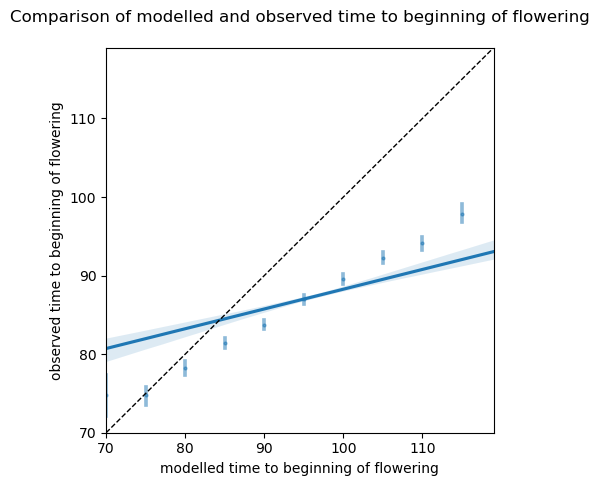

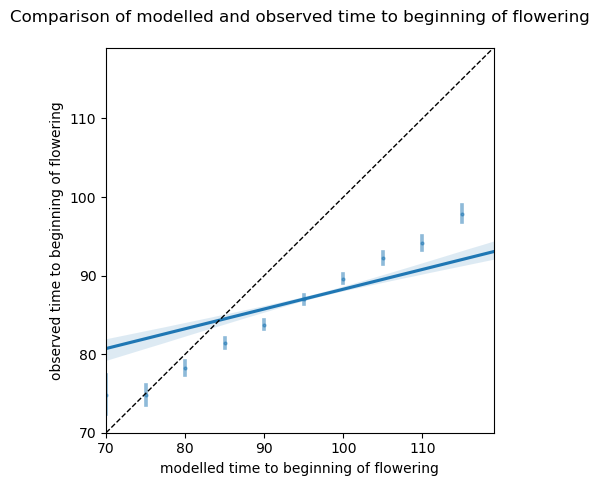

In [7]:
x1s = [np.array([0.5, 8, 28, 39, 0.5, 8, 28, 39])]#
r = run_GDD(x1s[0], ds_inputs_DE_reduced, 't2m', response_type='Wang', growing_period_length=300, thresholds=[10, 20], plot=True, method = 'regression')
r = run_GDD(x1s[0], ds_inputs_DE_reduced, 't2m', response_type='multi_phase', growing_period_length=300, thresholds=[10, 20], plot=True, method = 'regression')

In [8]:
thresholds = [10, 20]
thresholds_for_phase = thresholds[-1:]
print(thresholds_for_phase)

[20]


In [6]:
ds_inputs_DE_adjusted = ds_inputs_DE_reduced.copy()
ds_inputs_DE_adjusted[[f't2m at day {n}' for n in range(200)]] = ds_inputs_DE_reduced[[f't2m at day {n}' for n in range(30, 230)]]

In [11]:
def cols_in_other(df1, df2, compare_cols):
    index1 = pd.MultiIndex.from_arrays([df1[col] for col in compare_cols])
    index2 = pd.MultiIndex.from_arrays([df2[col] for col in compare_cols])
    return index1.isin(index2)

In [ ]:
x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
x1s = [np.array([0.5, 8, 28, 39])]#, 2, 5
train_a, test_a = train_test_split(ds_inputs_DE_adjusted, test_size=0.2, random_state = 1)
fm_flowering_tc_DE, res, train_a, test_a = local_opt(x1s, train_a, test_a, 
                     lower_bounds = [0.01, 7, 25, 38.5], upper_bounds = [5, 11, 31, 40],#38.5, 0.1, 0.5   , 5, 10
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=200,
                     test_size = 0.2, maxiter = 20, random_state = 2)

Optimization terminated successfully.
         Current function value: 13.502833
         Iterations: 76
         Function evaluations: 162
[ 0.5  8.  28.  39. ] [ 0.31615394  7.0000076  25.00438557 39.17739189] [ 0.18384606  0.9999924   2.99561443 -0.17739189]
RMSE at opt on test set:  17.087840128785174
R^2: -1.375457134449798


In [ ]:
x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
x1s = [np.array([0.5, 8, 28, 39])]#, 2, 5
train_a, test_a = train_test_split(ds_inputs_DE_adjusted, test_size=0.2, random_state = 1)
fm_flowering_tc_DE, res, train_a, test_a = local_opt(x1s, train_a, test_a, 
                     lower_bounds = [0.01, 7, 25, 38.5], upper_bounds = [5, 11, 31, 40],#38.5, 0.1, 0.5   , 5, 10
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=200,
                     test_size = 0.2, maxiter = 20, random_state = 2)

Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


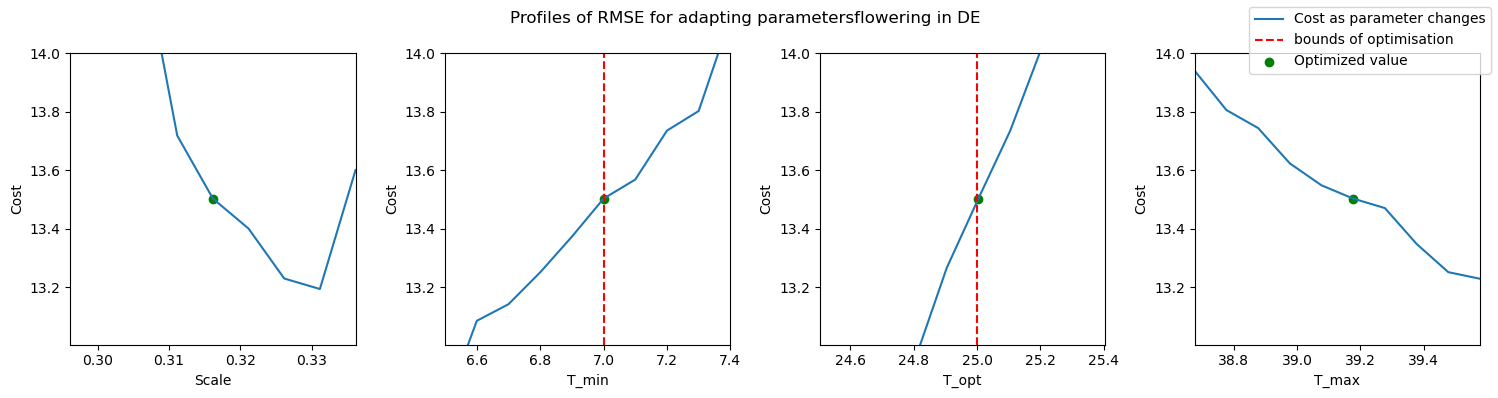

In [16]:
plot_profiles_at_minimum(fm_flowering_tc_DE[0], train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20], title = 'flowering in DE')

4 stations out of 1049 did not reach the end of phase 'beginning of flowering'
R^2 value for model: -0.39674106218267613
Bias: 3.280622245890351 (sign 1.0)
Variance of modelled values: 123.77767266535194


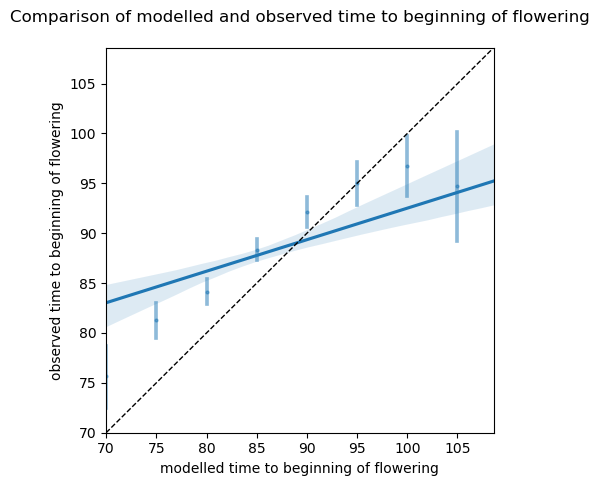

In [17]:
r = run_GDD(fm_flowering_tc_DE[0], test_a, 't2m', response_type='Wang', growing_period_length=200, thresholds=[20], plot=True, method='regression')

In [9]:
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML_fixed_photoperiod.csv')
ds_inputs_SSA = ds_inputs_SSA.rename(columns = {f't2m at day {n}': f'temperature at day {n}' for n in range(300)})
ds_inputs_SSA = ds_inputs_SSA.rename(columns = {'year': 'Referenzjahr'})
ds_inputs_SSA['observed time to beginning of flowering'] = pd.to_timedelta(ds_inputs_SSA['observed time to beginning of flowering'], 'D')

In [ ]:
x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
x1s = [np.array([0.5, 8, 28, 39])]#, 2, 5
fm_flowering_tc_DE, res = local_opt(x1s, ds_inputs_DE, 
                     lower_bounds = [0.01, 7, 25, 38.5], upper_bounds = [5, 11, 31, 40],#38.5, 0.1, 0.5   , 5, 10
                     great_threshold = 13, response_type = 'Convolved',
                     phase_list = ['beginning of flowering'],
                     method='trust-constr',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2, maxiter = 50, random_state = 2)

In [ ]:
x1s = [np.array([0.5, 8, 28, 39, 2, 3])]#])]#, 2, 3])]
#x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
fm_flowering_all_DE = local_opt(x1s, ds_inputs_DE, 
                     lower_bounds = [0.01, 7, 25, 38.5, 0.1, 0.5], upper_bounds = [5, 11, 31, 40, 5, 10],#, 0.1, 0.5], 5, 10
                     great_threshold = 13, response_type = 'Convolved',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2)

Optimization terminated successfully.
         Current function value: 8.523301
         Iterations: 128
         Function evaluations: 254
[ 0.5  8.  28.  39.   2.   3. ] [ 0.36327417  7.30339085 25.         39.10537745  2.28511994  3.53223723] [ 0.13672583  0.69660915  3.         -0.10537745 -0.28511994 -0.53223723]
RMSE at opt on test set:  8.672576443417832
R^2: 0.342555551931912


Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


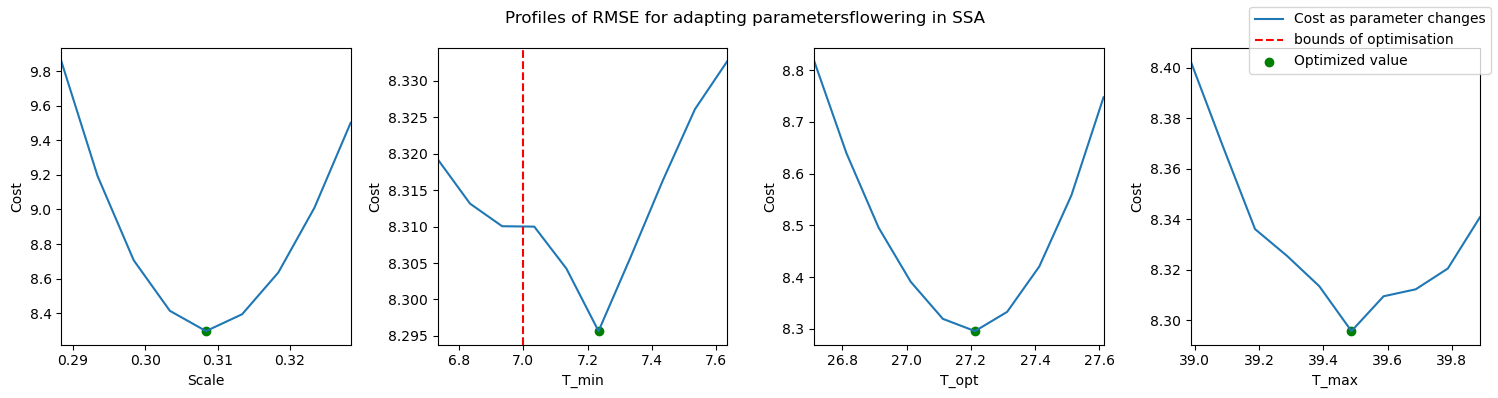

In [250]:
train_a, test_a = train_test_split(ds_inputs_DE, test_size=0.2, random_state = 1)
plot_profiles_at_minimum(fm_flowering_all_DE[0][0], train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 25, 38.5, 0.1, 0.5], ub = [5, 11, 31, 40, 5, 10], 
                         response_type = 'Convolved', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [20], title = 'flowering in SSA')

Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


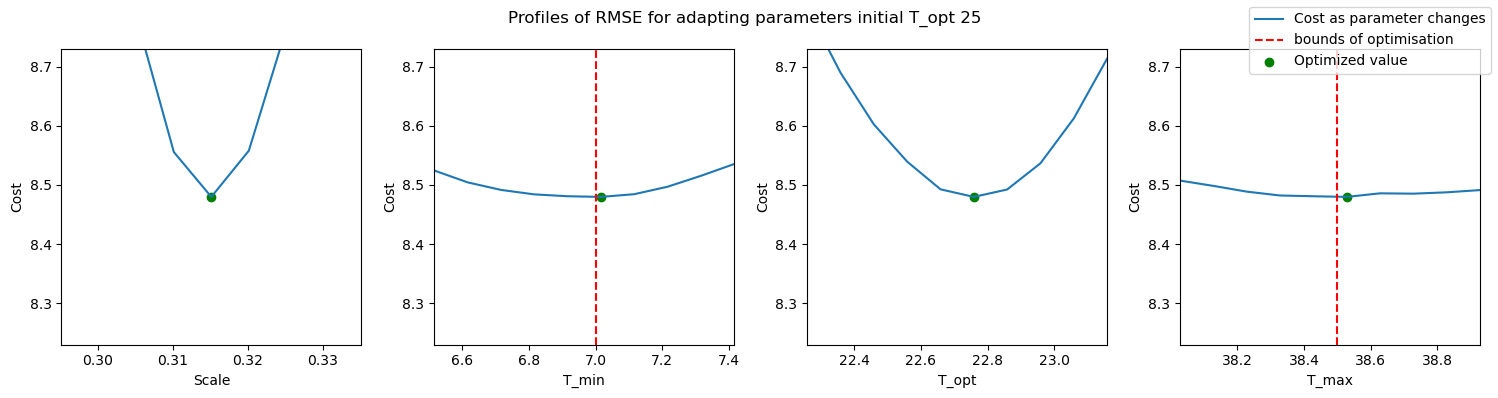

In [ ]:
plot_profiles_at_minimum(fm_flowering_all_DE5[0][0], fm_flowering_all_DE4[-2],
                         #error_fctn = run_GDD_supplemented_error,#train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 20, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [20], title = ' initial T_opt 25', plot_range = 0.25, bias_term = True)

In [17]:
fm_flowering_all_DE4 = [[[0.34525542, 7.00219008, 23.57229066, 39.02041395]], ds_inputs_DE, 0]
#fm_flowering_all_DE4 = [[[1.46684771, 8.23247775, 26.20979261, 38.95570421]], ds_inputs_DE, 0]
ds_inputs_DE_constant_flowering = ds_inputs_DE.copy()
ds_inputs_DE_constant_flowering['observed time to beginning of flowering'] = np.round(ds_inputs_DE_constant_flowering['observed time to beginning of flowering'].mean()).astype(int)
cf = run_GDD_transformed_space(fm_flowering_all_DE4[0][0], ds_inputs_DE_constant_flowering, #fm_flowering_all_DE4[-2],
                               't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
                               thresholds = [20])

((array([-10.54031968,  -9.65348893,  -9.18698236, ...,   9.18698236,
           9.65348893,  10.54031968], shape=(26208,)),
  array([ 57.,  59.,  59., ..., 126., 130., 132.], shape=(26208,))),
 (np.float64(4.936583218390187),
  np.float64(84.39377289377289),
  np.float64(0.9943858555965698)))

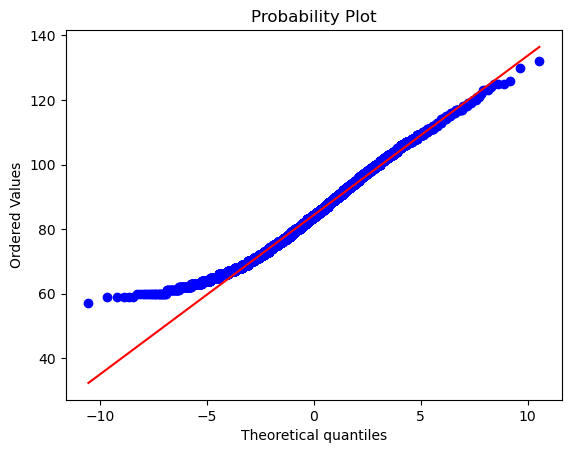

In [32]:
cf3['Error'] = cf3['observed time to beginning of flowering'] - cf3['modelled time to beginning of flowering']
#stats.probplot(cf2['Error'], dist="norm", plot=plt)  - cf2['observed time to beginning of flowering']
stats.probplot(cf3['modelled time to beginning of flowering'], dist=scipy.stats.logistic, plot=plt)# #gennorm(beta = 1.5)

<Axes: xlabel='modelled time to beginning of flowering', ylabel='Error'>

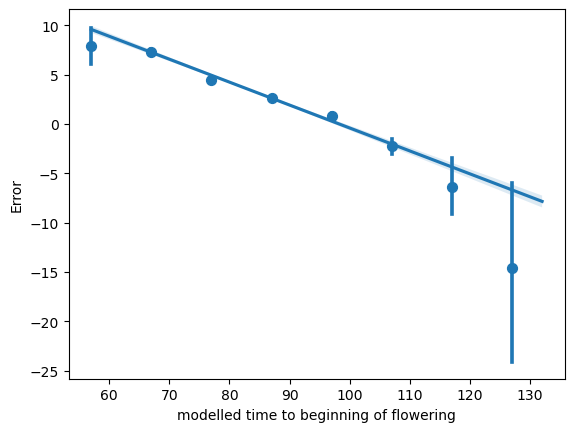

In [26]:
#cf_spread = pd.merge(cf_spread, cf3[['Referenzjahr', 'Stations_id', 'observed time to beginning of flowering']], on=['Referenzjahr', 'Stations_id'])
#cf_spread['Error'] = cf_spread['observed time to beginning of flowering'] - cf_spread['modelled time to beginning of flowering mean']
sns.regplot(y='Error', x = 'modelled time to beginning of flowering', data=cf3, x_bins=np.arange(cf3['modelled time to beginning of flowering'].min(), cf3['modelled time to beginning of flowering'].max(), 10))

((array([-4.04245198, -3.82951871, -3.71313745, ...,  3.71313745,
          3.82951871,  4.04245198], shape=(26208,)),
  array([ 33,  36,  41, ..., 138, 140, 145], shape=(26208,))),
 (np.float64(10.95996588695097),
  np.float64(87.61336233211233),
  np.float64(0.9966217317035899)))

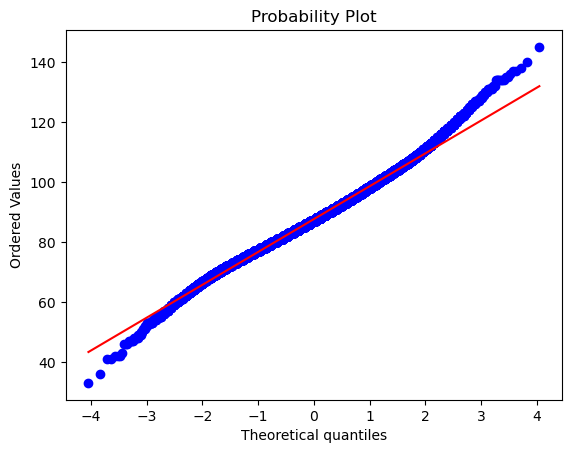

In [44]:
cf2['Error'] = cf2['observed time to beginning of flowering'] - cf2['modelled time to beginning of flowering']
#stats.probplot(cf2['Error'], dist="norm", plot=plt)
stats.probplot(cf2['observed time to beginning of flowering'], dist="norm", plot=plt) #gennorm(beta = 1.5)

<Axes: xlabel='modelled GDD at beginning of flowering', ylabel='Count'>

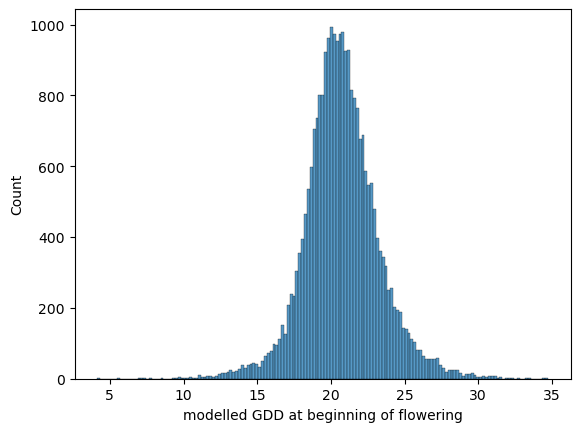

In [81]:
sns.histplot(cf['modelled GDD at beginning of flowering'])

In [82]:
cf['modelled GDD at beginning of flowering'].mean()

np.float64(20.752858495979694)

((array([-10.54031968,  -9.65348893,  -9.18698236, ...,   9.18698236,
           9.65348893,  10.54031968], shape=(26208,)),
  array([ 3.51301632,  4.50898622,  5.38536286, ..., 38.33207135,
         38.8517145 , 40.84185358], shape=(26208,))),
 (np.float64(1.7231882879637161),
  np.float64(21.39304488888339),
  np.float64(0.9979001026906007)))

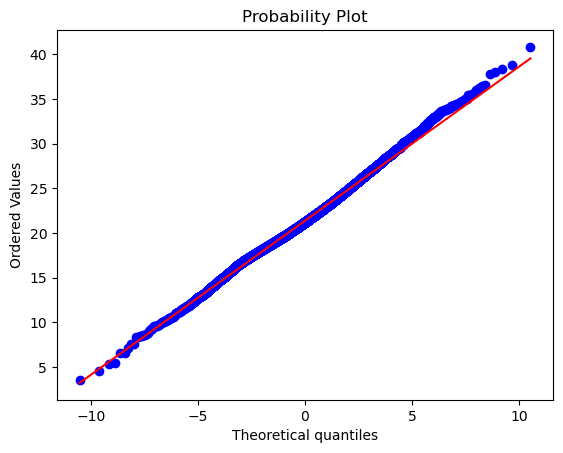

In [154]:

x = stats.cauchy(scale = 100)
fig, ax = plt.subplots()
x = stats.beta(a=3, b=2)
stats.probplot(cf4['modelled GDD at beginning of flowering'], dist=scipy.stats.logistic, plot = plt) #scipy.stats.logistic
#stats.probplot(cf['modelled GDD at beginning of flowering'], dist=scipy.stats.gennorm(beta = 1.5), plot = plt)

In [86]:
cf.loc[cf['modelled GDD at beginning of flowering'] < 40]

,observed time to beginning of flowering,Referenzjahr,Stations_id,modelled GDD before beginning of flowering,modelled GDD at beginning of flowering
73,57,1991,11620,30.612407,31.357741
182,72,2001,7807,37.945729,38.700292
428,79,1996,10865,31.576946,32.677657
532,63,1996,7700,32.370124,33.050820
627,60,2022,8556,36.098703,37.558094
714,60,1999,7807,29.054096,29.856594
837,64,1995,12898,26.398175,27.519621
933,71,1997,10865,28.006852,28.338366
957,49,2013,8793,29.234736,30.197942
1049,91,1996,8025,34.673834,35.043738


In [85]:
ds_inputs_DE_early['observed time to beginning of flowering'].min()

46

In [96]:
cf2 = run_GDD_transformed_space(x0, fm_flowering_all_DE2[-2],
                               't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
                               thresholds = [200])

<Axes: xlabel='modelled GDD at beginning of flowering', ylabel='Count'>

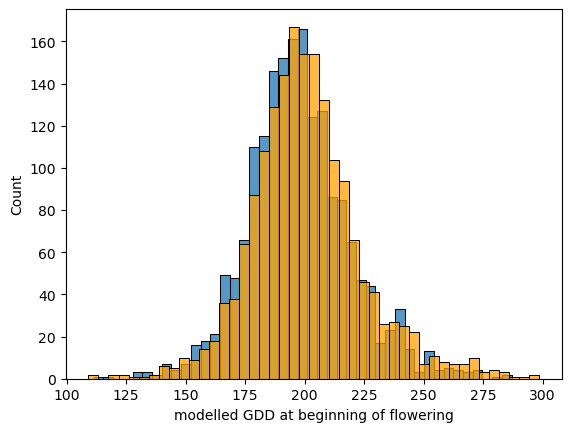

In [99]:
fig, ax = plt.subplots()
sns.histplot(cf['modelled GDD at beginning of flowering'], ax=ax, label='GDD optimised')
sns.histplot(cf2['modelled GDD at beginning of flowering']*10, ax=ax, label='RMSE optimised', color='orange')

NameError: name 'fm_flowering_all_DE2' is not defined

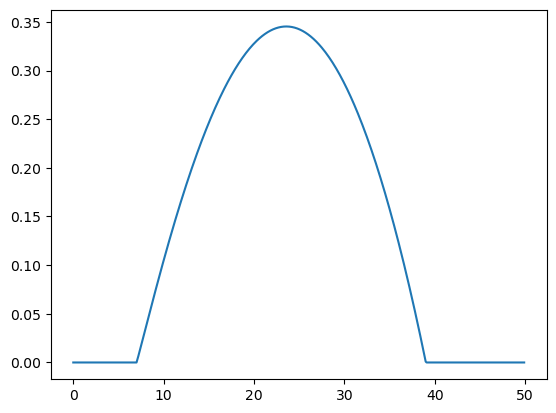

In [6]:
#fm_flowering_all_DE = [[fm_flowering_all_DE], ds_inputs_DE, 0, 1]
fm_flowering_all_DE = [[[0.34525542, 7.00219008, 23.57229066, 39.02041395]], ds_inputs_DE, 0]
xvals = np.arange(0, 50, 0.1)
fig, ax = plt.subplots()
ax.plot(xvals, fm_flowering_all_DE[0][0][0]*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE[0][0][1], fm_flowering_all_DE[0][0][2], fm_flowering_all_DE[0][0][3]), label = 'Init 28')
ax.plot(xvals, fm_flowering_all_DE2[0][0][0]*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE2[0][0][1], fm_flowering_all_DE2[0][0][2], fm_flowering_all_DE2[0][0][3]), label = 'Init 25')
ax.axvline(np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(300)]].values, 0.95), color = 'red', label = '95 percentlie')
ax.axvline(ds_inputs_DE['t2m at day 88'].mean(), color = 'green', label = 'Mean temp at mean day of flowering')
fig.legend()

In [ ]:
xvals = np.arange(0, 50, 0.1)
fig, ax = plt.subplots()
ax.plot(xvals, fm_flowering_all_DE[0][0][0]*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE[0][0][1], fm_flowering_all_DE[0][0][2], fm_flowering_all_DE[0][0][3]), label = 'Init 28')
ax.plot(xvals, fm_flowering_all_DE2[0][0][0]*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE2[0][0][1], fm_flowering_all_DE2[0][0][2], fm_flowering_all_DE2[0][0][3]), label = 'Init 25')
ax.axvline(np.quantile(comp_frame_25[[f'temperature at day {n}' for n in range(300)]].values, 0.95), color = 'red', label = '95 percentlie')
ax.axvline(comp_frame_25['temperature at day 88'].mean(), color = 'green', label = 'Mean temp at mean day of flowering')
fig.legend()

In [30]:
x_0 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x] + [9.3, 28.3, 39.2], ds_inputs_DE, 't2m', response_type='Wang', thresholds = [20], growing_period_length = 300),
                                            bounds = (0, 1),
                                            method='bounded',
                                            options = {'disp': 3})


 
 Func-count     x          f(x)          Procedure
    1       0.381966      97.9855        initial
    2       0.618034      15.8837        golden
    3       0.763932      13.2444        golden
    4       0.701462      12.0821        parabolic
    5       0.711547      12.0643        parabolic
    6       0.708775      12.0147        parabolic
    7       0.706833       12.086        parabolic
    8       0.709834       12.032        golden
    9       0.708033      12.0541        golden
   10       0.709092      12.0157        parabolic
   11       0.708839      12.0125        parabolic
   12       0.708922      12.0142        parabolic
   13       0.708853      12.0127        parabolic
   14       0.708814      12.0155        golden
   15        0.70883      12.0125        golden
   16       0.708826      12.0125        parabolic
   17       0.708822      12.0152        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xto

In [25]:
train_ds, test_ds = train_test_by_year(ds_inputs_DE, [2020, 2021, 2022])
x_1 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x] + [9.3, 28.3, 39.2], train_ds, 't2m', response_type='Convolved', thresholds = [20], growing_period_length = 200),
                                            bounds = (0, 1),
                                            method='bounded',
                                            options = {'disp': 3})


 
 Func-count     x          f(x)          Procedure
    1       0.381966      44.4787        initial
    2       0.618034      8.79257        golden
    3       0.763932      17.9988        golden
    4        0.63474      9.41451        parabolic
    5       0.527864      12.8106        golden
    6       0.602063      8.52429        parabolic
    7       0.596615      8.52741        parabolic
    8       0.599693       8.5241        parabolic
    9       0.600695      8.52367        parabolic
   10       0.600774       8.5232        parabolic
   11       0.601267      8.52355        golden
   12        0.60099      8.52453        parabolic
   13       0.600777      8.52338        parabolic
   14       0.600744      8.52314        golden
   15       0.600758      8.52319        parabolic
   16       0.600725      8.52334        golden
   17       0.600737      8.52341        golden
   18       0.600749      8.52307        golden
   19       0.600753        8.523        parabolic

Opt

In [33]:
train_ds, test_ds = train_test_split(ds_inputs_DE)
x_1 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x] + [9.3, 28.3, 39.2], train_ds, 't2m', response_type='Wang', thresholds = [20], growing_period_length = 200),
                                            bounds = (0, 1),
                                            method='bounded',
                                            options = {'disp': 3})

 
 Func-count     x          f(x)          Procedure
    1       0.381966      61.1105        initial
    2       0.618034      12.7404        golden
    3       0.763932       13.086        golden
    4         0.6888      11.2436        parabolic
    5         0.6872      11.2284        parabolic
    6       0.677296       11.286        parabolic
    7       0.683417      11.2234        golden
    8       0.684866      11.2298        parabolic
    9       0.681079      11.2381        golden
   10       0.682524       11.229        golden
   11        0.68397      11.2217        golden
   12       0.684313       11.226        golden
   13       0.683783      11.2285        parabolic
   14       0.684101      11.2242        golden
   15       0.683899      11.2196        golden
   16       0.683854      11.2194        golden
   17        0.68386      11.2194        parabolic
   18       0.683827      11.2193        golden
   19       0.683838      11.2195        parabolic
   20        

0 stations out of 1637 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.3698804311985494
Bias: 15.621085250258504 (sign 1.0)
Variance of modelled values: 39.37252383377673


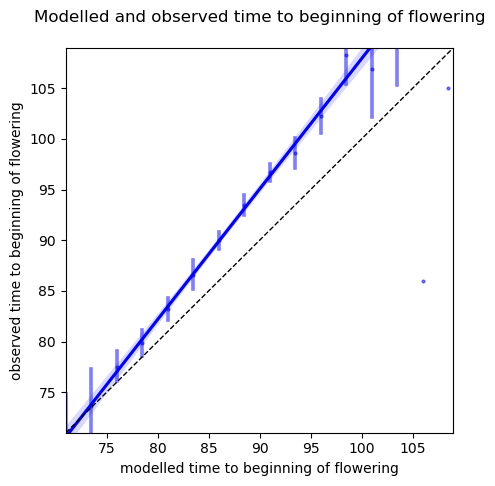

In [28]:
cf = run_GDD([x_1.x, 9.3, 28.3, 39.2], test_ds, 't2m', response_type='Convolved', growing_period_length=300, thresholds=[10, 20], plot=True, method = 'regression')

In [10]:
x_low_opt = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x] + [8.13, 22.84, 38.88], ds_inputs_DE, 't2m', response_type='Wang', thresholds = [20], growing_period_length = 200),
                                            bounds = (0, 1),
                                            method='bounded',
                                            options = {'disp': 3})

 
 Func-count     x          f(x)          Procedure
    1       0.381966      13.3616        initial
    2       0.618034      35.0549        golden
    3       0.236068      28.7589        golden
    4       0.411106      16.9033        parabolic
    5       0.349691       9.7483        parabolic
    6       0.306291      9.62642        golden
    7       0.327018       8.5324        parabolic
    8       0.327419      8.53418        parabolic
    9       0.326395      8.53253        parabolic
   10        0.32678      8.53101        golden
   11       0.326713      8.53135        parabolic
   12       0.326818       8.5312        parabolic
   13       0.326773      8.53118        parabolic
   14       0.326796      8.53109        parabolic
   15       0.326786      8.53109        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1e-05 )


In [11]:
x_ML = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x] + [3.6, 21.6, 37.4], ds_inputs_DE, 't2m', response_type='Wang', thresholds = [20], growing_period_length = 200),
                                            bounds = (0, 1),
                                            method='bounded',
                                            options = {'disp': 3})

 
 Func-count     x          f(x)          Procedure
    1       0.381966      22.4841        initial
    2       0.618034      44.1988        golden
    3       0.236068      16.4943        golden
    4       0.155066      69.8523        parabolic
    5       0.291796       9.1817        golden
    6       0.298273      9.84601        parabolic
    7       0.281389      8.63066        parabolic
    8       0.264078      9.72728        golden
    9       0.280283      8.62467        parabolic
   10       0.280179       8.6236        parabolic
   11       0.274029      8.76427        golden
   12        0.27783       8.6338        golden
   13       0.279282      8.62002        golden
   14       0.279416      8.62315        parabolic
   15       0.278728      8.62345        golden
   16       0.279077      8.62015        parabolic
   17       0.279184      8.61975        parabolic
   18       0.279189       8.6195        parabolic
   19        0.27923      8.61987        parabolic
   2

In [7]:
x_conv = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x] + [9.3, 28.3, 39.2, 8, 3], ds_inputs_DE, 't2m', response_type='Convolved_vary_spread', thresholds = [20], growing_period_length = 200),
                                            bounds = (0, 1),
                                            method='bounded',
                                            options = {'disp': 3})

 
 Func-count     x          f(x)          Procedure
    1       0.381966      41.1321        initial
    2       0.618034      9.18858        golden
    3       0.763932      18.3218        golden
    4       0.630575      9.73608        parabolic
    5       0.527864       11.584        golden
    6       0.592378      8.60943        parabolic
    7       0.584755        8.613        parabolic
    8       0.588904      8.59741        parabolic
    9       0.588814      8.59793        parabolic
   10       0.589971      8.60062        parabolic
   11       0.589312      8.59771        golden
   12        0.58908      8.59771        parabolic
   13       0.588971      8.59696        golden
   14       0.589013       8.5973        golden
   15       0.588962      8.59732        parabolic
   16       0.588988      8.59694        parabolic
   17       0.588997      8.59704        golden
   18       0.588981      8.59716        parabolic
   19       0.588991      8.59697        golden
   2

In [9]:
x_conv2 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x] + [9.3, 28.3, 39.2, 9, 3], ds_inputs_DE, 't2m', response_type='Convolved_vary_spread', thresholds = [20], growing_period_length = 200),
                                            bounds = (0, 1),
                                            method='bounded',
                                            options = {'disp': 3})

 
 Func-count     x          f(x)          Procedure
    1       0.381966      42.0894        initial
    2       0.618034        9.071        golden
    3       0.763932      18.4406        golden
    4       0.630886       9.6288        parabolic
    5       0.527864      11.8937        golden
    6       0.594534      8.54639        parabolic
    7       0.587033      8.54962        parabolic
    8       0.591077      8.54136        parabolic
    9       0.591245      8.54054        parabolic
   10       0.592427      8.53966        parabolic
   11       0.593232      8.54052        golden
   12       0.592246      8.54169        parabolic
   13       0.592734      8.53932        golden
   14       0.592708      8.54001        parabolic
   15       0.592924      8.53929        golden
   16       0.592876      8.53871        parabolic
   17        0.59283      8.53853        parabolic
   18       0.592827      8.53875        parabolic
   19       0.592852      8.53858        paraboli

In [14]:
x1s = [np.array([0.5, 8, 28, 39, 2, 3])]#])]#, 2, 3])]
train_a, test_a = train_test_split(ds_inputs_DE_reduced, test_size=0.2, random_state = 1)
fm_flowering_all_DE = local_opt(x1s, train_a, test_a,# ds_inputs_DE_early, 
                     lower_bounds = [0.01, 7, 25, 38.5, 0.1, 0.5], upper_bounds = [5, 11, 31, 40, 5, 10],#, 0.1, 0.5], 5, 10
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2)

Optimization terminated successfully.
         Current function value: 8.549878
         Iterations: 179
         Function evaluations: 357
[ 0.5  8.  28.  39.   2.   3. ] [ 0.37934956  7.0094127  25.16467337 39.17442218  2.5360532   4.80742285] [ 0.12065044  0.9905873   2.83532663 -0.17442218 -0.5360532  -1.80742285]
RMSE at opt on test set:  8.622525756933404
R^2: 0.3951581205056638


In [1]:
x1s = [np.array([0.5, 8, 28, 39, 2, 3])]#])]#, 2, 3])]
train_a, test_a = train_test_split(ds_inputs_DE_reduced, test_size=0.2, random_state = 1)
fm_flowering_all_DE = local_opt(x1s, train_a, test_a,# ds_inputs_DE_early, 
                     lower_bounds = [0.01, 7, 25, 38.5, 0.1, 0.5], upper_bounds = [5, 11, 31, 40, 5, 10],#, 0.1, 0.5], 5, 10
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2)

NameError: name 'np' is not defined

In [19]:
1 - (run_GDD_and_get_RMSE([x_1.x, 9.3, 28.3, 39.2], ds_inputs_DE, 't2m', response_type='Convolved', thresholds = [20])**2)/ds_inputs_DE['observed time to beginning of flowering'].var()

np.float64(0.3012636409400622)

Text(0.5, 1.0, 'Wang response functions with parameters\nfrom optimisation or literature')

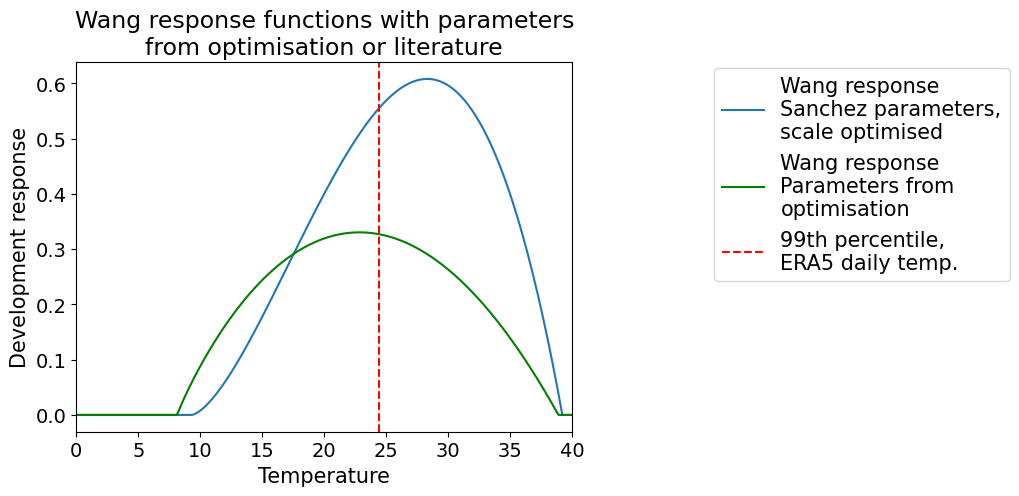

In [35]:
font_size = 15
fm_flowering_all_DE2 = [[[x_1.x, 9.3, 28.3, 39.2]], 'ds_inputs_DE_reduced', 0]#[[[0.503004, 7.02058042, 27.00252239, 39.30655295]], 'ds_inputs_DE_reduced', 0]
fm_flowering_all_DE = [[[x_3.x, 8.13380267, 22.83931163, 38.88095627], ds_inputs_DE, 0]]#[[[0.34525542, 7.00219008, 23.57229066, 39.02041395]], ds_inputs_DE, 0]
x = fm_flowering_all_DE2[0][0]
xvals = np.arange(0, 50, 0.1)
fig, ax = plt.subplots()
ax.plot(xvals, x[0]*modelling_fctns.Wang_Engel_Temp_response(xvals, x[1], x[2], x[3]), label = 'Wang response\nSanchez parameters,\nscale optimised')#fm_flowering_all_DE2[0][0][0]
ax.plot(xvals, fm_flowering_all_DE[0][0][0]*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE[0][0][1], fm_flowering_all_DE[0][0][2], fm_flowering_all_DE[0][0][3]), label = 'Wang response\nParameters from\noptimisation', color = 'green')
#ax.set_title('Convolution SD in box of 7, temp range in day of 6')

ax.axvline(np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(300)]].values, 0.99), color = 'red', linestyle = '--', label = '99th percentile,\nERA5 daily temp.')
#ax.axvline(np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(300)]].values, 0.01), color = 'red', linestyle = '--', label = '2nd percentile,\nERA5 daily temp.')
#ax.axvline(ds_inputs_DE['t2m at day 88'].mean(), color = 'red', linestyle = ':', label = 'Mean temp at mean day of flowering')
#ax.axvline(28.3, color = 'k', linestyle = '--', label = 'optimal temp from\nSanchez et al.')
#ax.axvline(fm_flowering_all_DE[0][0][2], color = 'k', label = 'optimal temp from optimisation')
ax.set_xlim(0, 40)
ax.tick_params(axis='both', labelsize = font_size - 1)
ax.set_xlabel('Temperature', fontsize = font_size)
ax.set_ylabel('Development response', fontsize = font_size)
fig.legend(bbox_to_anchor=(1.6, 0.89), fontsize = font_size)
ax.set_title('Wang response functions with parameters\nfrom optimisation or literature', fontsize = font_size + 2)

Text(-80, -10, 'Poor skill, parameters\nfrom literature')

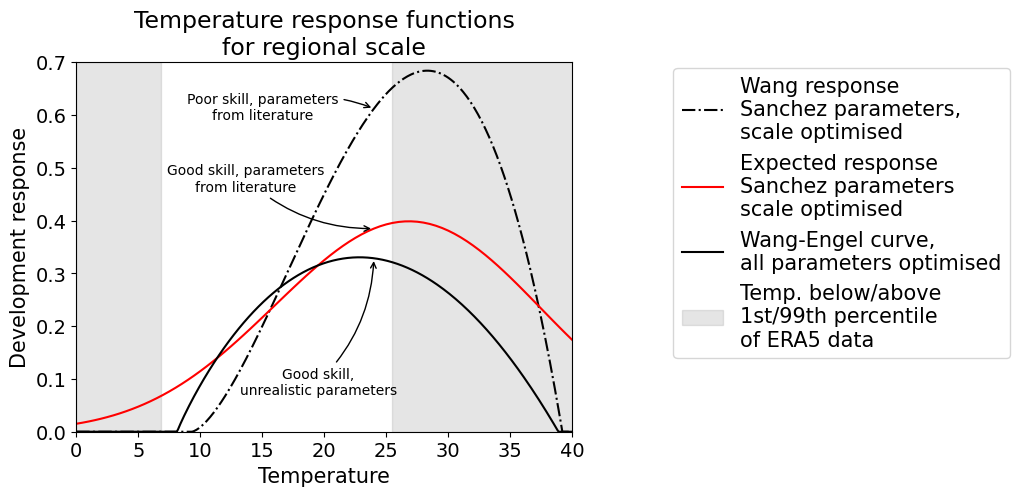

In [77]:
font_size = 15
table = vec_expint(9.3, 28.3, 39.2, np.arange(0, 50, 0.5), 8, 3)#, x[4], x[5])#x[2]
fm_flowering_all_DE2 = [[[x_1.x, 9.3, 28.3, 39.2]], 'ds_inputs_DE_reduced', 0]#[[[0.503004, 7.02058042, 27.00252239, 39.30655295]], 'ds_inputs_DE_reduced', 0]
fm_flowering_all_DE = [[[x_3.x, 8.13380267, 22.83931163, 38.88095627], ds_inputs_DE, 0]]#[[[0.34525542, 7.00219008, 23.57229066, 39.02041395]], ds_inputs_DE, 0]
x = fm_flowering_all_DE2[0][0]
xvals = np.arange(0, 50, 0.1)
fig, ax = plt.subplots()
ax.plot(xvals, x[0]*modelling_fctns.Wang_Engel_Temp_response(xvals, x[1], x[2], x[3]), label = 'Wang response\nSanchez parameters,\nscale optimised', linestyle = '-.', color = 'k')#fm_flowering_all_DE2[0][0][0]
ax.plot(np.arange(0, 50, 0.5), x_0_conv.x*table, label = 'Expected response\nSanchez parameters\nscale optimised', color = 'red')
ax.plot(xvals, fm_flowering_all_DE[0][0][0]*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE[0][0][1], fm_flowering_all_DE[0][0][2], fm_flowering_all_DE[0][0][3]), 
        label = 'Wang-Engel curve,\nall parameters optimised', color='k')
#ax.set_title('Convolution SD in box of 7, temp range in day of 6')
percentile_99 = np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.99)
percentile_1 = np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.01)
#ax.axvline(np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.99), color = 'k', linestyle = ':', label = '99th percentile,\nERA5 daily temp.')
#ax.axvline(np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(150)]].values, 0.01), color = 'k', linestyle = '--', label = '1st percentile,\nERA5 daily temp.')
ax.fill_betweenx([0, 0.7], [0, 0], [percentile_1, percentile_1], color = 'gray', alpha = 0.2, label = 'Temp. below/above\n1st/99th percentile\nof ERA5 data')
ax.fill_betweenx([0, 0.7], [percentile_99, percentile_99], [50, 50], color = 'gray', alpha = 0.2)
#ax.axvline(ds_inputs_DE['t2m at day 88'].mean(), color = 'red', linestyle = ':', label = 'Mean temp at mean day of flowering')
#ax.axvline(28.3, color = 'k', linestyle = '--', label = 'optimal temp from\nSanchez et al.')
#ax.axvline(fm_flowering_all_DE[0][0][2], color = 'k', label = 'optimal temp from optimisation')
ax.set_xlim(0, 40)
ax.set_ylim(0, 0.7)
ax.tick_params(axis='both', labelsize = font_size - 1)
ax.set_xlabel('Temperature', fontsize = font_size)
ax.set_ylabel('Development response', fontsize = font_size)
fig.legend(bbox_to_anchor=(1.6, 0.89), fontsize = font_size)
ax.set_title('Temperature response functions\nfor regional scale', fontsize = font_size + 2)
conv_ylabel = x_0_conv.x*table[48]
conv_xlabel = np.arange(0, 50, 0.5)[48]
ax.annotate('Good skill, parameters\nfrom literature',
            xy=(conv_xlabel, conv_ylabel), xycoords='data',
            xytext=(-92, 25), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=0.2"),
            horizontalalignment='center', verticalalignment='bottom')
wang_ylabel = fm_flowering_all_DE[0][0][0]*modelling_fctns.Wang_Engel_Temp_response(24, fm_flowering_all_DE[0][0][1], fm_flowering_all_DE[0][0][2], fm_flowering_all_DE[0][0][3])
wang_xlabel = 24
ax.annotate('Good skill,\nunrealistic parameters',
            xy=(wang_xlabel, wang_ylabel), xycoords='data',
            xytext=(-40, -100), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=.2"),
            horizontalalignment='center', verticalalignment='bottom')
sanchez_ylabel = x[0]*modelling_fctns.Wang_Engel_Temp_response(24, x[1], x[2], x[3])
sanchez_xlabel = 24
ax.annotate('Poor skill, parameters\nfrom literature',
            xy=(sanchez_xlabel, sanchez_ylabel), xycoords='data',
            xytext=(-80, -10), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                    connectionstyle="arc3,rad=-.2"),
            horizontalalignment='center', verticalalignment='bottom')

In [29]:
x_2 = scipy.optimize.minimize_scalar(lambda y: run_GDD_and_get_RMSE([y] + [7, 27, 39], ds_inputs_DE, 't2m', response_type='Wang', thresholds = [20], growing_period_length = 300),
                                            bounds = (0, 1),
                                            method='bounded',
                                            options = {'disp': 3})

 
 Func-count     x          f(x)          Procedure
    1       0.381966      21.0104        initial
    2       0.618034      17.2764        golden
    3       0.763932      26.1994        golden
    4       0.539244      11.7032        parabolic
    5       0.514371      10.2208        parabolic
    6       0.463797      9.58082        golden
    7       0.478916      9.31499        parabolic
    8       0.481665       9.2581        parabolic
    9       0.494158      9.41008        golden
   10        0.48509      9.22594        parabolic
   11       0.485943      9.23659        parabolic
   12       0.484296      9.21523        parabolic
   13       0.483291      9.20758        golden
   14       0.482631      9.20399        parabolic
   15       0.482262      9.25638        golden
   16       0.482883      9.20614        golden
   17        0.48249       9.2023        golden
   18       0.482403       9.2576        golden
   19       0.482544      9.20214        golden
   20     

In [31]:
x_3 = scipy.optimize.minimize_scalar(lambda y: run_GDD_and_get_RMSE([y] + [7.00219008, 23.57229066, 39.02041395], ds_inputs_DE, 't2m', response_type='Wang', thresholds = [20], growing_period_length = 300),
                                            bounds = (0, 1),
                                            method='bounded',
                                            options = {'disp': 3})

 
 Func-count     x          f(x)          Procedure
    1       0.381966      12.7455        initial
    2       0.618034      34.8104        golden
    3       0.236068      30.9761        golden
    4       0.418274      17.1551        parabolic
    5       0.355216      9.77672        parabolic
    6       0.309705      9.66869        golden
    7       0.331671      8.47622        parabolic
    8       0.331968      8.47958        parabolic
    9       0.329898      8.47495        parabolic
   10       0.322185      8.65801        golden
   11       0.330714      8.47455        parabolic
   12       0.330501       8.4738        parabolic
   13       0.330344      8.47206        parabolic
   14       0.330174      8.47424        golden
   15       0.330347      8.47215        parabolic
   16       0.330279      8.47299        golden
   17       0.330323      8.47212        parabolic
   18       0.330335      8.47239        parabolic
   19        0.33034      8.47206        paraboli

[20] 26208
96 stations out of 26208 did not reach the end of phase 'beginning of flowering'
R^2 value for model: -0.43727597049950306
Bias: 22.550177201948653 (sign -1.0)
Variance of modelled values: 196.55303411459406


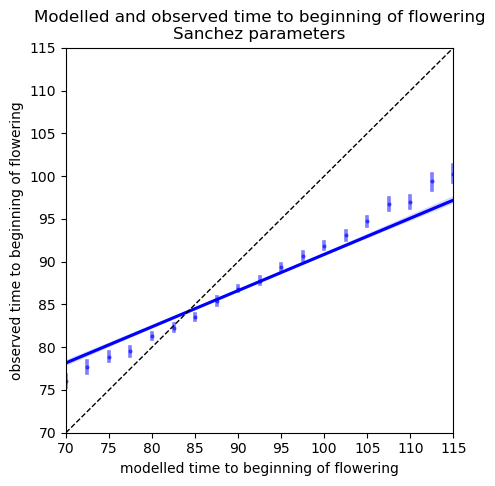

In [18]:
comp_frame_27 =run_GDD([x_1.x, 9.3, 28.3, 39.2], ds_inputs_DE, 't2m', response_type='Wang',#_early fm_flowering_all_DE2[0][0]
        phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=200,
        thresholds = [20], title_extra='Sanchez parameters', method = 'regression', plot=True, col='blue')

[20] 26208
0 stations out of 26208 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.3971048419446469
Bias: 0.057583151415427795 (sign -1.0)
Variance of modelled values: 40.25154309404654


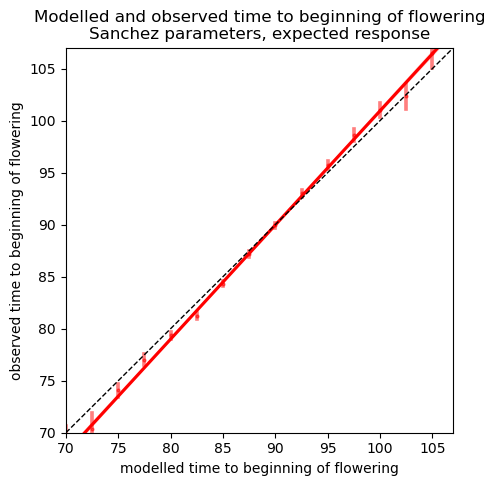

In [36]:
comp_frame_27 =run_GDD([x_0_conv.x, 9.3, 28.3, 39.2], ds_inputs_DE, 't2m', response_type='Convolved',#_early fm_flowering_all_DE2[0][0]
        phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=200,
        thresholds = [20], title_extra='Sanchez parameters, expected response', method = 'regression', plot=True, col='red')

0 stations out of 26208 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.29959459187573756
Bias: 0.6736170337217625 (sign 1.0)
Variance of modelled values: 101.47364798790335


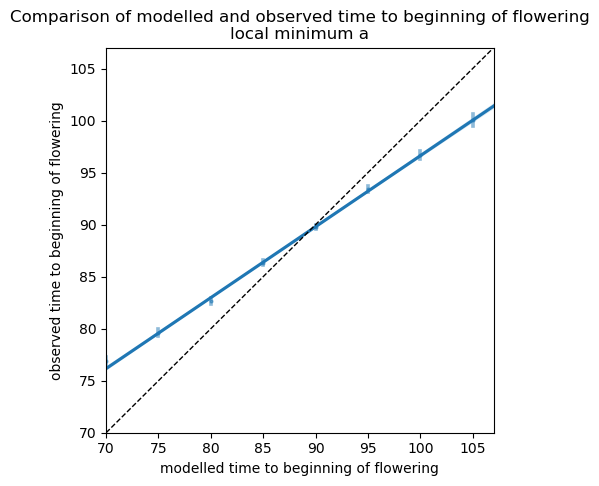

In [30]:
comp_frame_27 =run_GDD([x_2.x, 7, 27, 39], ds_inputs_DE, 't2m', response_type='Wang',#_early fm_flowering_all_DE2[0][0]
        phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=200,
        thresholds = [20], title_extra='local minimum a', method = 'regression', plot=True)

[20] 26208
0 stations out of 26208 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.4063238585864336
Bias: 0.0035430839002268378 (sign -1.0)
Variance of modelled values: 62.8286584840788


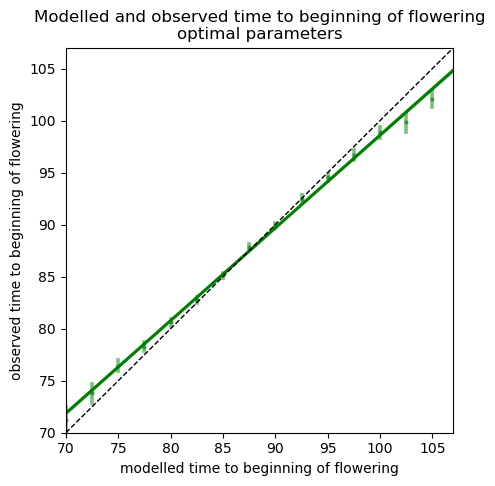

In [21]:
comp_frame_27 =run_GDD([x_3.x, 7.00219008, 23.57229066, 39.02041395], ds_inputs_DE, 't2m', response_type='Wang',#_early fm_flowering_all_DE[0][0]
        phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=200,
        thresholds = [20], title_extra='optimal parameters', method = 'regression', plot=True, col='green')

Text(0.5, 1.0, 'Wang response functions with experimental parameters\nand integration')

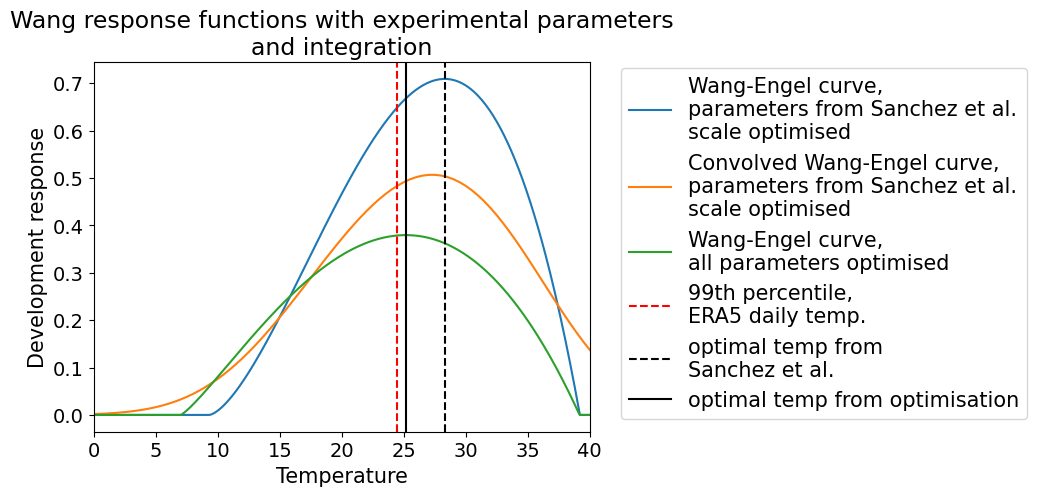

In [29]:
font_size = 15
fm_flowering_all_DE2 = [[[0.503004, 9.3, 28.3, 39.2]], 'ds_inputs_DE_reduced', 0]#[[[0.503004, 7.02058042, 27.00252239, 39.30655295]], 'ds_inputs_DE_reduced', 0]
x = fm_flowering_all_DE2[0][0]
table = vec_expint(x[1], x[2], x[3], np.arange(0, 50, 0.5), 5, 3)#, x[4], x[5])#x[2]
def response(meantemp):
    return x[0]*table[(np.round(meantemp/5, decimals = 1)*10).astype(int)]*(meantemp > 0)
xvals = np.arange(0, 50, 0.1)
fig, ax = plt.subplots()
ax.plot(xvals, x_0.x*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE2[0][0][1], fm_flowering_all_DE2[0][0][2], fm_flowering_all_DE2[0][0][3]), label = 'Wang-Engel curve,\nparameters from Sanchez et al.\nscale optimised')#fm_flowering_all_DE2[0][0][0]
ax.plot(np.arange(0, 50, 0.5), x_1.x*np.array(table), label = 'Convolved Wang-Engel curve,\nparameters from Sanchez et al.\nscale optimised')
ax.plot(xvals, fm_flowering_all_DE[0][0][0]*modelling_fctns.Wang_Engel_Temp_response(xvals, fm_flowering_all_DE[0][0][1], fm_flowering_all_DE[0][0][2], fm_flowering_all_DE[0][0][3]), label = 'Wang-Engel curve,\nall parameters optimised')
#ax.set_title('Convolution SD in box of 7, temp range in day of 6')

ax.axvline(np.quantile(ds_inputs_DE[[f't2m at day {n}' for n in range(300)]].values, 0.99), color = 'red', linestyle = '--', label = '99th percentile,\nERA5 daily temp.')
#ax.axvline(ds_inputs_DE['t2m at day 88'].mean(), color = 'red', linestyle = ':', label = 'Mean temp at mean day of flowering')
ax.axvline(28.3, color = 'k', linestyle = '--', label = 'optimal temp from\nSanchez et al.')
ax.axvline(fm_flowering_all_DE[0][0][2], color = 'k', label = 'optimal temp from optimisation')
ax.set_xlim(0, 40)
ax.tick_params(axis='both', labelsize = font_size - 1)
ax.set_xlabel('Temperature', fontsize = font_size)
ax.set_ylabel('Development response', fontsize = font_size)
fig.legend(bbox_to_anchor=(1.6, 0.89), fontsize = font_size)
ax.set_title('Wang response functions with experimental parameters\nand integration', fontsize = font_size + 2)

In [24]:
fm_flowering_all_DE = np.array([0.36883787, 7.33177754, 25.34427389, 39.48075322])

In [155]:
np.quantile(comp_frame_25_lates[[f'temperature at day {n}' for n in range(300)]].values, 0.9)

np.float64(18.066341534667767)

In [8]:
comp_frame_25 =run_GDD(fm_flowering_all_DE4[0][0], ds_inputs_DE, 't2m', response_type='Wang',#_early
        phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
        thresholds = [20], title_extra='Early varieties', method = 'regression', plot=False)
comp_frame_28 =run_GDD(fm_flowering_all_DE2[0][0], ds_inputs_DE, 't2m', response_type='Wang',#_early
        phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300,
        thresholds = [20], title_extra='Early varieties', method = 'regression', plot=False)

NameError: name 'fm_flowering_all_DE4' is not defined

In [134]:
comp_frame_25.loc[:, [f'acc_response at day {n}' for n in range(300)]] = fm_flowering_all_DE4[0][0][0]*modelling_fctns.Wang_Engel_Temp_response(comp_frame_25[[f'temperature at day {n}' for n in range(300)]].values, fm_flowering_all_DE4[0][0][1], fm_flowering_all_DE4[0][0][2], fm_flowering_all_DE4[0][0][3])
comp_frame_28.loc[:, [f'acc_response at day {n}' for n in range(300)]] = fm_flowering_all_DE2[0][0][0]*modelling_fctns.Wang_Engel_Temp_response(comp_frame_28[[f'temperature at day {n}' for n in range(300)]].values, fm_flowering_all_DE2[0][0][1], fm_flowering_all_DE2[0][0][2], fm_flowering_all_DE2[0][0][3])

In [135]:
fm_flowering_all_DE2[0][0]

[0.503004, 7.02058042, 27.00252239, 39.30655295]

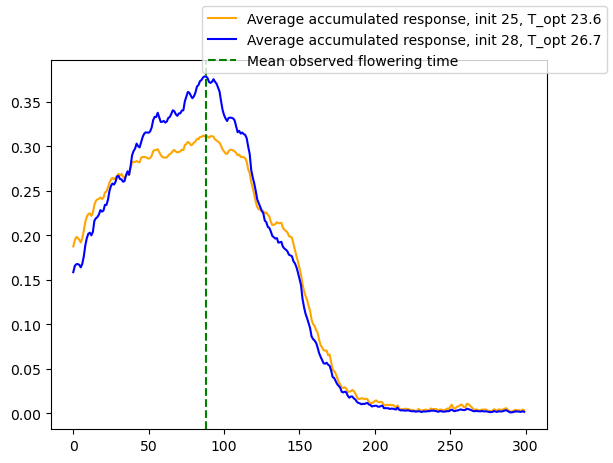

In [137]:
comp_frame_25_lates = comp_frame_25.loc[comp_frame_25['modelled time to beginning of flowering'] < 80]
comp_frame_28_lates = comp_frame_28.loc[comp_frame_28['modelled time to beginning of flowering'] < 80]
fig, ax = plt.subplots()
ax.plot(range(300), comp_frame_25_lates.loc[:, [f'acc_response at day {n}' for n in range(300)]].mean(axis=0), label = 'Average accumulated response, init 25, T_opt 23.6', color = 'orange')
ax.plot(range(300), comp_frame_28_lates.loc[:, [f'acc_response at day {n}' for n in range(300)]].mean(axis=0), label = 'Average accumulated response, init 28, T_opt 26.7', color = 'blue')

ax.axvline(x = comp_frame_25['observed time to beginning of flowering'].mean(), color='green', linestyle='--', label='Mean observed flowering time')
fig.legend()

KeyError: "None of [Index(['acc_response at day 0', 'acc_response at day 1',\n       'acc_response at day 2', 'acc_response at day 3',\n       'acc_response at day 4', 'acc_response at day 5',\n       'acc_response at day 6', 'acc_response at day 7',\n       'acc_response at day 8', 'acc_response at day 9',\n       ...\n       'acc_response at day 290', 'acc_response at day 291',\n       'acc_response at day 292', 'acc_response at day 293',\n       'acc_response at day 294', 'acc_response at day 295',\n       'acc_response at day 296', 'acc_response at day 297',\n       'acc_response at day 298', 'acc_response at day 299'],\n      dtype='object', length=300)] are in the [columns]"

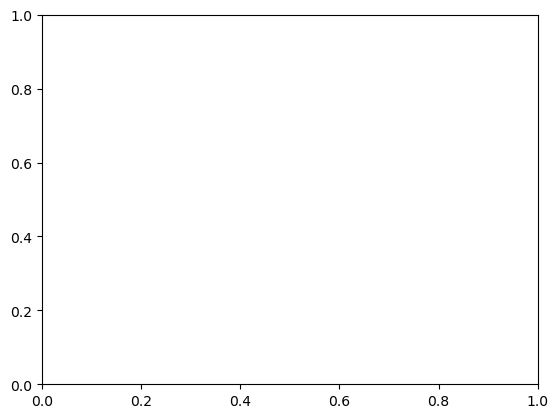

In [20]:
fig, ax = plt.subplots()
mean_25 = comp_frame_25.loc[:, [f'acc_response at day {n}' for n in range(300)]].mean(axis=0)
var_25 = comp_frame_25.loc[:, [f'acc_response at day {n}' for n in range(300)]].var(axis=0)
mean_28 = comp_frame_28.loc[:, [f'acc_response at day {n}' for n in range(300)]].mean(axis=0)
var_28 = comp_frame_28.loc[:, [f'acc_response at day {n}' for n in range(300)]].var(axis=0)
ax.plot(range(300), comp_frame_25.loc[:, [f'acc_response at day {n}' for n in range(300)]].mean(axis=0), label = 'Average accumulated response, init 25, T_opt 23.6', color = 'orange')
ax.fill_between(range(300), mean_25 - np.sqrt(var_25), mean_25 + np.sqrt(var_25), color = 'orange', alpha = 0.3)
ax.plot(range(300), comp_frame_28.loc[:, [f'acc_response at day {n}' for n in range(300)]].mean(axis=0), label = 'Average accumulated response, init 28, T_opt 26.7', color = 'blue')
ax.fill_between(range(300), mean_28 - np.sqrt(var_28), mean_28 + np.sqrt(var_28), color = 'blue', alpha = 0.3)
#ax.set_ylim((0, 25))
#ax.set_xlim((0, 120))
#ax.axhline(y=20, color='red', linestyle='--', label='Threshold')
ax.axvline(x = comp_frame_25['observed time to beginning of flowering'].dt.days.mean(), color='green', linestyle='--', label='Mean observed flowering time')
fig.legend()

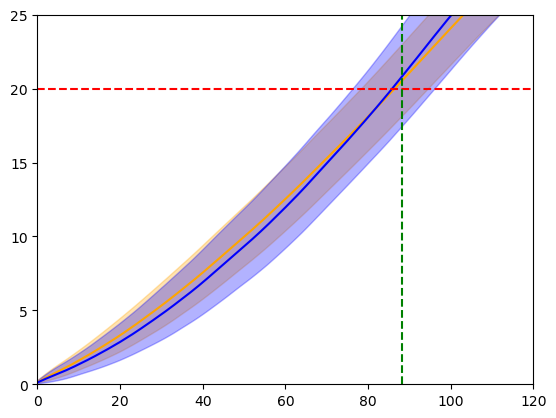

In [139]:
fig, ax = plt.subplots()
mean_cumsum_25 = comp_frame_25.loc[:, [f'acc_response at day {n}' for n in range(300)]].cumsum(axis=1).mean(axis=0)
var_cumsum_25 = comp_frame_25.loc[:, [f'acc_response at day {n}' for n in range(300)]].cumsum(axis=1).var(axis=0)
mean_cumsum_28 = comp_frame_28.loc[:, [f'acc_response at day {n}' for n in range(300)]].cumsum(axis=1).mean(axis=0)
var_cumsum_28 = comp_frame_28.loc[:, [f'acc_response at day {n}' for n in range(300)]].cumsum(axis=1).var(axis=0)
ax.plot(range(300), mean_cumsum_25, label = 'Average accumulated response, init 25', color = 'orange')
ax.fill_between(range(300), mean_cumsum_25 - np.sqrt(var_cumsum_25), mean_cumsum_25 + np.sqrt(var_cumsum_25), color = 'orange', alpha = 0.3)
ax.plot(range(300), comp_frame_28.loc[:, [f'acc_response at day {n}' for n in range(300)]].cumsum(axis=1).mean(axis=0), label = 'Average accumulated response, init 28', color = 'blue')
ax.fill_between(range(300), mean_cumsum_28 - np.sqrt(var_cumsum_28), mean_cumsum_28 + np.sqrt(var_cumsum_28), color = 'blue', alpha = 0.3)
ax.set_ylim((0, 25))
ax.set_xlim((0, 120))
ax.axhline(y=20, color='red', linestyle='--', label='Threshold')
ax.axvline(x = comp_frame_25['observed time to beginning of flowering'].mean(), color='green', linestyle='--', label='Mean observed flowering time')

In [177]:
ds = train_a
phase_list = ['beginning of flowering']
growing_period_length = 300
thresholds = [20]

lb = [0.01, 7, 20, 38.5]
ub = [5, 11, 31, 40]
bounds = scipy.optimize.Bounds(lb=lb[:2], ub = ub[:2])
x_list = []
for T_opt in np.arange(21, 30, 0.5)[:2]:
    print(f'Optimising T_opt = {T_opt}')
    fixed_params = [T_opt, 39]
    x0 = [0.5, 8]
    x = scipy.optimize.minimize(lambda x: run_GDD_and_get_RMSE([x[0], x[1]] + fixed_params, ds, 't2m', response_type='Wang', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                 x0, method = 'Nelder-Mead',
                                    options={'disp': True},#, 'maxiter':50
                                    bounds=bounds)
    x_list.append(x)
    print(x)


Optimising T_opt = 21.0
Optimization terminated successfully.
         Current function value: 8.297087
         Iterations: 47
         Function evaluations: 98
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 8.297087394551648
             x: [ 2.925e-01  7.031e+00]
           nit: 47
          nfev: 98
 final_simplex: (array([[ 2.925e-01,  7.031e+00],
                       [ 2.925e-01,  7.031e+00],
                       [ 2.925e-01,  7.031e+00]]), array([ 8.297e+00,  8.297e+00,  8.297e+00]))
Optimising T_opt = 21.5
Optimization terminated successfully.
         Current function value: 8.245860
         Iterations: 44
         Function evaluations: 96
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 8.245859664444284
             x: [ 2.993e-01  7.020e+00]
           nit: 44
          nfev: 96
 final_simplex: (array([[ 2.993e-01,  7.020e+00],
                     

In [27]:
ds = ds_inputs_DE_reduced
phase_list = ['beginning of flowering']
growing_period_length = 300
thresholds = [20]
lb = [0.01, 7, 20, 38.5]
ub = [5, 11, 31, 40]
x_0_list3 = []
for T_opt in np.arange(20, 23, 0.5):
    print(f'Optimising T_opt = {T_opt}')
    fixed_params = [7.5, T_opt, 39]
    x_0 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x] + fixed_params, ds, 't2m', response_type='Convolved', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                                bounds = (lb[0], ub[0]),
                                                method='bounded',
                                                options = {'disp': 3})
    x_0_list3.append(x_0)
    print(x_0)


Optimising T_opt = 20.0
 
 Func-count     x          f(x)          Procedure
    1        1.91601      69.4551        initial
    2        3.09399       76.492        golden
    3        1.18798      58.9979        golden
    4       0.738031      43.7924        golden
    5       0.459948      21.9199        golden
    6       0.288083      16.6493        golden
    7       0.230244      39.1871        parabolic
    8       0.365636      9.98704        parabolic
    9        0.36161      9.60283        parabolic
   10       0.344275      8.61155        parabolic
   11       0.322812      9.67231        golden
   12       0.342537      8.58441        parabolic
   13       0.339826       8.5982        parabolic
   14       0.341728      8.58302        parabolic
   15       0.341893      8.58473        parabolic
   16       0.341002       8.5834        golden
   17       0.341543      8.58509        parabolic
   18       0.341658      8.58355        golden
   19       0.341791      8.581

In [28]:
x_0_list2 = x_0_list3 + x_0_list2

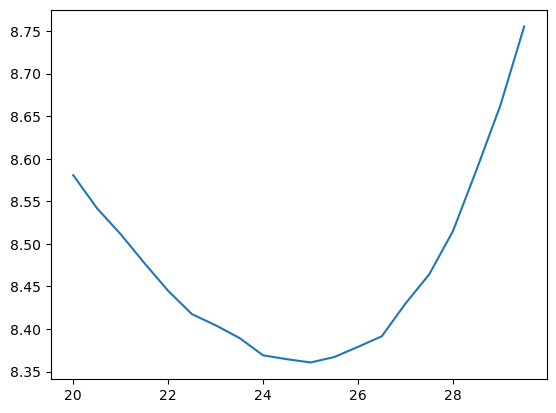

In [29]:
fig, ax = plt.subplots()
#ax.plot(np.arange(21, 30, 0.5), [x_0['x'] for x_0 in x_0_list])
RMSEs = [x_0['fun'] for x_0 in x_0_list2]
ax.plot(np.arange(20, 30, 0.5), RMSEs)

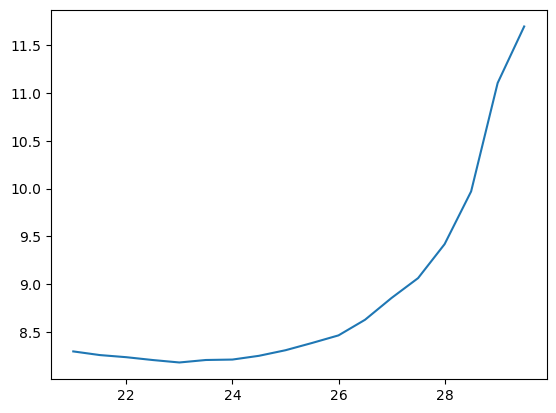

In [175]:
fig, ax = plt.subplots()
#ax.plot(np.arange(21, 30, 0.5), [x_0['x'] for x_0 in x_0_list])
RMSEs = [x_0['fun'] for x_0 in x_0_list]
ax.plot(np.arange(21, 30, 0.5), RMSEs)

In [61]:
x1s = [np.array([0.5, 8, 30, 39])]#[np.array([0.5, 7.5, 25, 39])]#
#x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
train_a, test_a = train_test_split(ds_inputs_DE_early, test_size=0.2, random_state = 1)
fm_flowering_all_DE3 = local_opt(x1s, train_a, test_a,# ds_inputs_DE_early, 
                     lower_bounds = [0.01, 7, 20, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.2, maxiter = 50, random_state = 1)

Optimization terminated successfully.
         Current function value: 8.618254
         Iterations: 84
         Function evaluations: 172
[ 0.5  8.  30.  39. ] [ 0.503004    7.02058042 27.00252239 39.30655295] [-0.003004    0.97941958  2.99747761 -0.30655295]
RMSE at opt on test set:  8.546402647750035
R^2: 0.373829045123407


0 stations out of 561 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.34508471756281545
Bias: 1.2651237127487525 (sign 1.0)
Variance of modelled values: 106.14377387318557
Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


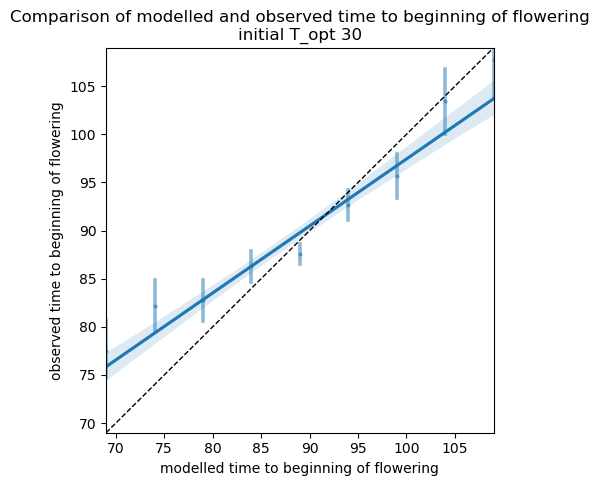

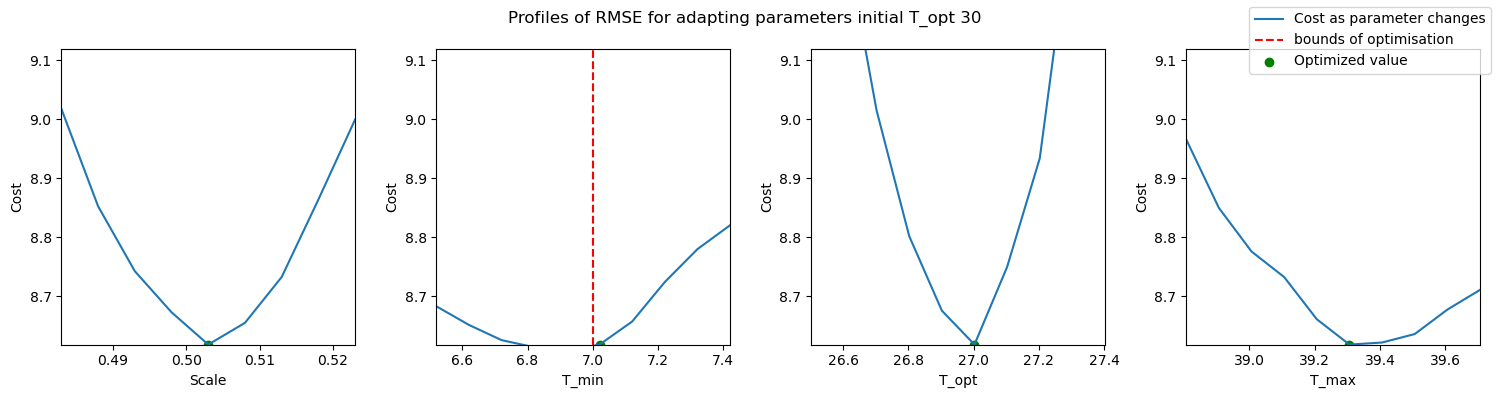

In [63]:
#train_a, test_a = train_test_split(ds_inputs_DE_early, test_size=0.2, random_state = 1)
c_array = run_GDD(fm_flowering_all_DE[0][0], test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20], title_extra='initial T_opt 30', method = 'regression', plot=True)
plot_profiles_at_minimum(fm_flowering_all_DE3[0][0], fm_flowering_all_DE[-2],#train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 20, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [20], title = ' initial T_opt 30')

0 stations out of 561 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.34508471756281545
Bias: 1.2651237127487525 (sign 1.0)
Variance of modelled values: 106.14377387318557
Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


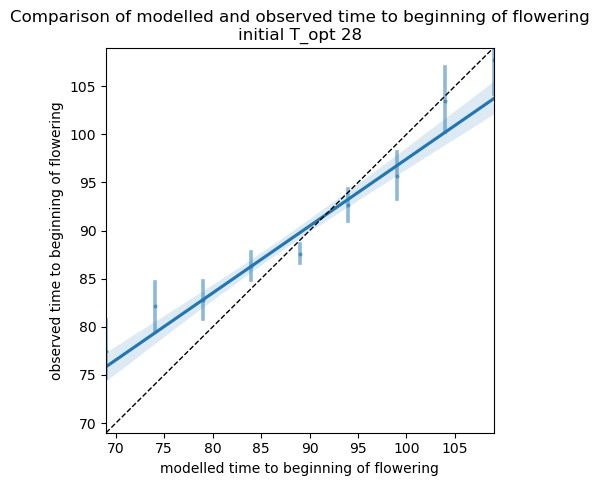

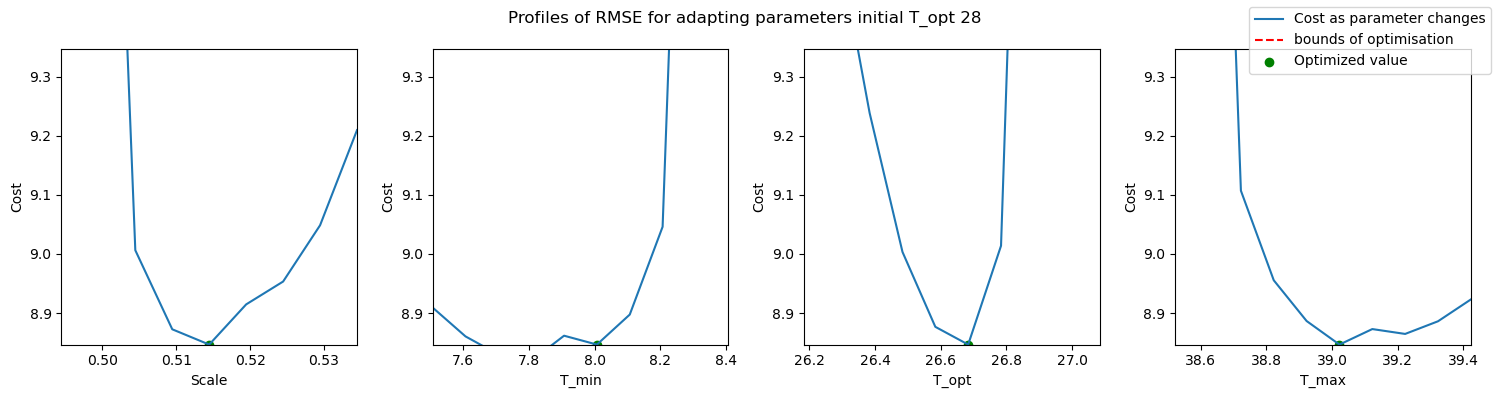

In [64]:
#train_a, test_a = train_test_split(ds_inputs_DE_early, test_size=0.2, random_state = 1)
c_array = run_GDD(fm_flowering_all_DE[0][0], test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20], title_extra='initial T_opt 28', method = 'regression', plot=True)
plot_profiles_at_minimum(fm_flowering_all_DE[0][0], fm_flowering_all_DE[-2],#train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 20, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [20], title = ' initial T_opt 28')

In [102]:
fm_flowering_all_DE2[0][0]

array([ 0.34525542,  7.00219008, 23.57229066, 39.02041395])

0 stations out of 561 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.45605829903279316
Bias: 0.45640742117621186 (sign 1.0)
Variance of modelled values: 66.34161573720408
Plotting Scale
Plotting T_min
Plotting T_opt
Plotting T_max


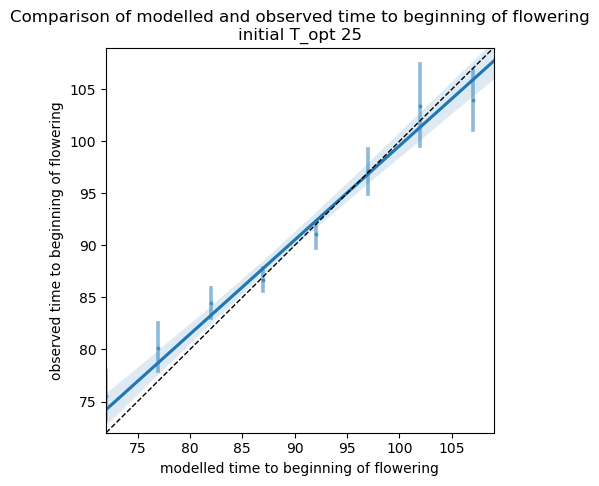

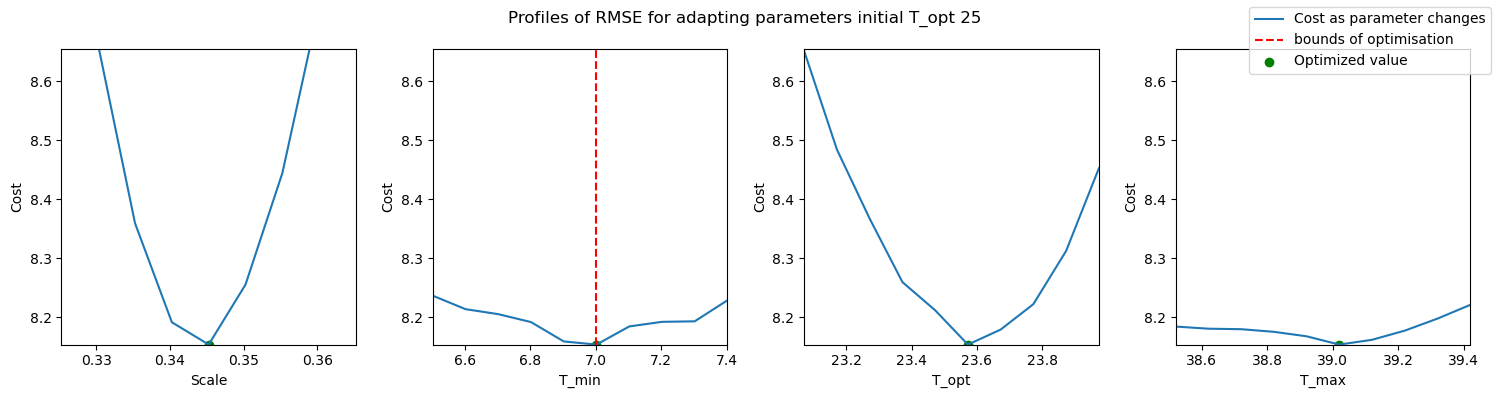

In [65]:
c_array = run_GDD(fm_flowering_all_DE2[0][0], test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20], title_extra='initial T_opt 25', method = 'regression', plot=True)
plot_profiles_at_minimum(fm_flowering_all_DE2[0][0], fm_flowering_all_DE[-2],#train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 20, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=300, new_unfinished_penalisation=False,
                         thresholds = [20], title = ' initial T_opt 25')

R^2 value for model: 0.413846226926438
Bias: 0.04473681486465441 (sign 1.0)
Variance of modelled values: 77.052308552582


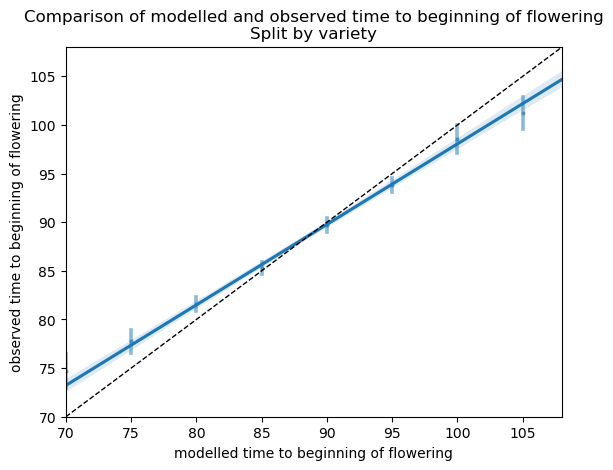

In [89]:
fig, axs = plt.subplots()
phase = 'beginning of flowering'
title_extra = 'Split by variety'
minval = min(separate_params[f'observed time to {phase}'].quantile(0.05), separate_params[f'modelled time to {phase}'].quantile(0.05)) - 1
maxval = max(separate_params[f'observed time to {phase}'].quantile(0.95), separate_params[f'modelled time to {phase}'].quantile(0.95)) + 1
sns.regplot(x=f'modelled time to {phase}', y=f'observed time to {phase}', data=separate_params, ax=axs,
            scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 5))
axs.plot([minval, maxval], [minval, maxval], linestyle='--', color='k', lw=1, scalex=False, scaley=False)
axs.set_xlim(minval, maxval)
axs.set_ylim(minval, maxval)
axs.set_title(f'Comparison of modelled and observed time to {phase}\n{title_extra}')
rsquared = r2_score(separate_params[f'observed time to {phase}'], separate_params[f'modelled time to {phase}'])
print(f'R^2 value for model: {rsquared}')
bias = separate_params[f'observed time to {phase}'].mean() - separate_params[f'modelled time to {phase}'].mean()
variance_modelled = separate_params[f'modelled time to {phase}'].var()
print(f'Bias: {bias**2} (sign {np.sign(bias)})\nVariance of modelled values: {variance_modelled}')

0 stations out of 2780 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.4318997536927216
Bias: 0.18663643186170398 (sign 1.0)
Variance of modelled values: 59.744035430166626


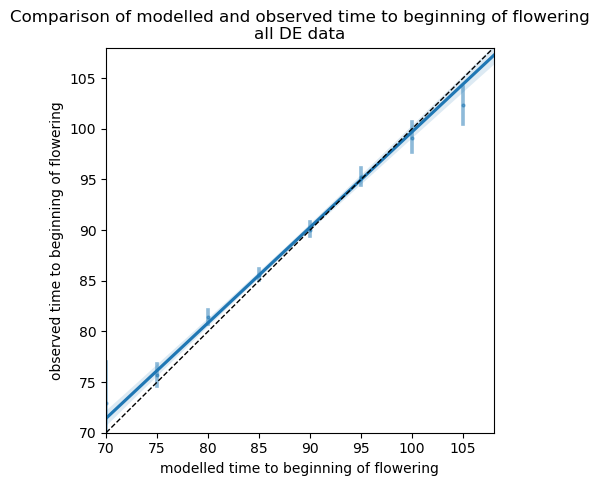

In [93]:
c_array = run_GDD(fm_flowering_all_DE_all[0][0], test_b, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20], title_extra='all DE data', method = 'regression', plot=True)

In [ ]:
x1s = [np.array([0.32531922, 7.11557392, 25.30018333, 39.35554162])]
x1s = [np.array([0.5, 8, 28, 39])]
fm_flowering_tc, res = local_opt(x1s, ds_inputs_SSA, 
                     lower_bounds = [0.01, 7, 27, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='trust-constr',
                     thresholds = [20], growing_period_length=300,
                     test_size = 0.5, maxiter = 100, random_state = 1)

In [ ]:
x_opt = one_by_one_optimisation(fm_flowering_tc[0], train_a, #np.array(x_opt)
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=300,
                         thresholds = [20])

In [15]:
x1s = [np.array([0.3, 6, 29.5, 42])]
#x1s = [fms[0]]
fm_all_ripeness, res = local_opt(x1s, ds2, 
                     lower_bounds = [0.01, 5, 28, 38], upper_bounds = [10, 7.5, 33, 44],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['yellow ripeness'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=200,
                     maxiter = 300)

Optimization terminated successfully.
         Current function value: 14.168034
         Iterations: 130
         Function evaluations: 237
[ 0.3  6.  29.5 42. ] [ 0.24281304  5.00383729 28.15685861 43.96110362] [ 0.05718696  0.99616271  1.34314139 -1.96110362]
RMSE at opt on test set:  19.941897092174766
R^2: -0.029379434800168136


In [ ]:
plot_profiles_at_minimum(fm3s[0], train_a, #fm2s[0], ds2, #fm2s[0]
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=200, new_unfinished_penalisation=False,
                         thresholds = [20])

In [40]:
x1s = [np.array([0.8, 8, 28, 39])]
fm_flowering_all_DE = local_opt(x1s, ds_DE, 
                     lower_bounds = [0.01, 7, 25, 38.5], upper_bounds = [5, 11, 31, 40],
                     great_threshold = 13, response_type = 'Wang',
                     phase_list = ['beginning of flowering'],
                     method='Nelder-Mead',
                     thresholds = [20], growing_period_length=200)

Optimization terminated successfully.
         Current function value: 9.838051
         Iterations: 138
         Function evaluations: 274
[ 0.8  8.  28.  39. ] [ 0.60195695  8.2342903  28.64357561 39.46867037] [ 0.19804305 -0.2342903  -0.64357561 -0.46867037]
RMSE at opt on test set:  10.001840890158821
R^2: 0.0766758382928796


In [36]:
parameter_data = np.concatenate([np.array([fm_all_ripeness[0]]), 
                                 np.array([fm2s[0]]), np.array([fms[0]]), 
                                 np.array([fm_flowering_all[0][0]]), 
                                 np.array([fm5s[0]]), 
                                 np.array([fm6s[0]])], axis=0)

In [47]:
column_names = ['Scale (thermal time requirement)', 'T_min', 'T_opt',  'T_max']
row_names = np.array(['Full set, ripeness', 'Warm set, ripeness', 'Cold set, ripeness',
                      'Full set, flowering', 'Warm set, flowering', 'Cold set, flowering'])
R2s = np.array([-0.029379434800168136, 0.33311833790242984, 0.12521048556632275,
                0.3281956184199428, 0.3372506254579203, 0.35085707964200563])
parameters_frame = pd.DataFrame(parameter_data, columns = column_names, index = row_names)
parameters_frame['R2'] = R2s

In [62]:
np.round(parameters_frame, decimals = 2)

,Scale,T_min,T_opt,T_max,R2
"Full set, ripeness",0.24,5.00,28.16,43.96,-0.03
"Warm set, ripeness",0.23,5.02,28.03,43.68,0.33
"Cold set, ripeness",0.25,5.01,28.02,43.70,0.13
"Full set, flowering",0.38,7.01,25.07,38.89,0.33
"Warm set, flowering",0.38,7.86,25.01,38.67,0.34
"Cold set, flowering",0.38,7.08,25.02,39.64,0.35


In [15]:
def one_by_one_optimisation(x0, ds, lb, ub, phase_list = ['yellow ripeness'], thresholds = [10], growing_period_length = 200, response_type = 'Wang', ):
    fixed_params = x0.copy()[1:].tolist()
    x_0 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x] + fixed_params, ds, 't2m', response_type='Wang', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                                bounds = (lb[0], ub[0]),
                                                method='bounded',
                                                options = {'disp': 3})

    T_min = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x_0.x, x] + fixed_params[1:], ds, 't2m', response_type='Wang', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                                bounds = (lb[1], ub[1]),
                                                method='bounded',
                                                options = {'disp': 3})
                            
    T_opt = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x_0.x, T_min.x, x] + fixed_params[2:], ds, 't2m', response_type='Wang', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                                bounds = (lb[2], ub[2]),
                                                method='bounded',
                                                options = {'disp': 3})
    T_max = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x_0.x, T_min.x, T_opt.x, x], ds, 't2m', response_type='Wang', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                                bounds = (lb[3], ub[3]),
                                                method='bounded',
                                                options = {'disp': 3})

    x_0 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x, T_min.x, T_opt.x, T_max.x], ds, 't2m', response_type='Wang', phase_list = phase_list, thresholds = thresholds, growing_period_length = growing_period_length),
                                                bounds = (lb[0], ub[0]),
                                                method='bounded',
                                                options = {'disp': 3})


    x_opt = [x_0.x, T_min.x, T_opt.x, T_max.x]
    return x_opt

In [20]:
x_opt = one_by_one_optimisation(fm3s[0], train_a,
                         lb=[0.01, 7, 25, 38.5], ub = [5, 11, 31, 40], 
                         response_type = 'Wang', phase_list = ['beginning of flowering'],
                         growing_period_length=200,
                         thresholds = [20])

 
 Func-count     x          f(x)          Procedure
    1        1.91601      46.0385        initial
    2        3.09399      55.7688        golden
    3        1.18798       33.381        golden
    4       0.738031      16.4724        golden
    5       0.459948      17.5153        golden
    6       0.632022      10.8563        parabolic
    7       0.604678      9.86623        parabolic
    8       0.549396      9.82621        golden
    9       0.576194      9.44314        parabolic
   10        0.57635      9.44053        parabolic
   11        0.58717      9.52115        golden
   12       0.580067      9.44998        parabolic
   13       0.577953      9.45067        parabolic
   14       0.576354      9.44093        parabolic
   15       0.576282      9.44159        parabolic
   16       0.576324      9.44061        golden
   17       0.576338      9.44071        parabolic
   18       0.576345       9.4405        golden
   19       0.576342      9.44068        parabolic

Opt

In [18]:
def global_search(ds, param_values,
                     N = 200, 
                     interesting_threshold = 16, great_threshold = 13, response_type = 'Wang',
                     phase_list = ['yellow ripeness']):
    np.random.seed(10)
    count_tested = 0
    results_array = pd.DataFrame(columns = ['Tmin', 'Topt', 'Tmax', 'optimised scale', 'RMSE'])
    for Tmin_index, Tmin in enumerate(param_values[0]):
        for Topt_index, Topt in enumerate(param_values[1]):
            for Tmax_index, Tmax in enumerate(param_values[2]):
                x0 = [0.12, Tmin, Topt, Tmax]
                constraint_violation = x0[1] < x0[0] or x0[2] < x0[1]
                if constraint_violation:
                    print(x0, 'goes against constraints')
                    continue
                fixed_params = [Tmin, Topt, Tmax]
                x_0 = scipy.optimize.minimize_scalar(lambda x: run_GDD_and_get_RMSE([x] + fixed_params, ds, 't2m', response_type=response_type, phase_list = phase_list),
                                                    bounds = (0.05, 1.5),
                                                    method='bounded',
                                                    options = {'disp': 2})
                x1 = np.array([x_0.x] + fixed_params)
                opt_value = run_GDD_and_get_RMSE(x1, ds, 't2m', response_type=response_type,  phase_list = phase_list)
                new_row = pd.DataFrame({'Tmin':[Tmin], 'Topt':[Topt], 'Tmax':[Tmax], 'optimised scale':[x1[0]], 'RMSE':[opt_value]})
                count_tested += 1
                print(f'{count_tested} samples considered')
                results_array = pd.concat([results_array, new_row])
                print(results_array)
    return results_array

0 stations out of 114 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.23804860204298983
Bias: 3.6904432132963905 (sign -1.0)
Variance of modelled values: 99.94853283651608


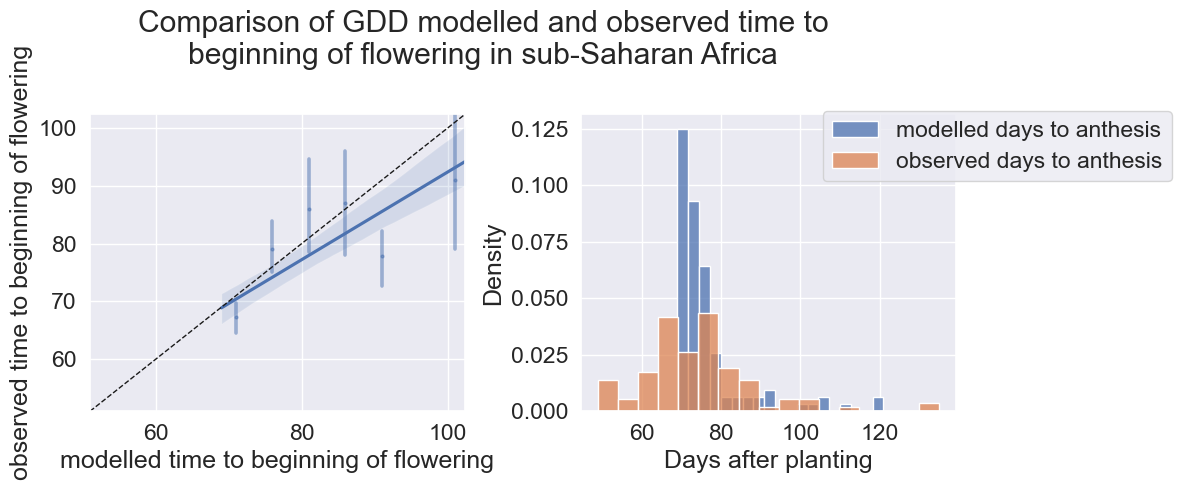

In [79]:
fm_flowering_all_DE = np.array([0.34020292, 7.24511043, 24.10650321, 39.69694962])#DE params
#fm_flowering_all_DE = np.array([0.29237735, 7.5983653, 24.73654165, 39.54685523])#SSA params
fm_flowering_all_DE = np.array([0.29432022, 7.00296687, 25.27906453, 39.96888553])
#fm_flowering_all_DE = np.array([0.37700293, 7.93566179, 28.01052802, 39.95536985])
train_a, test_a = train_test_split(ds_inputs_SSA, test_size=0.5, random_state = 1)
ca_flowering = run_GDD_and_plot(fm_flowering_all_DE, test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20],  method = 'both', title_extra = 'in sub-Saharan Africa', savename = 'SSA_GDD_skill.png')#np.concatenate((np.array([0.5]), fm_flowering_all[0][0][1:]))

0 stations out of 3061 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.4191269675053191
Bias: 0.0038528361730301858 (sign 1.0)
Variance of modelled values: 81.44009817800546


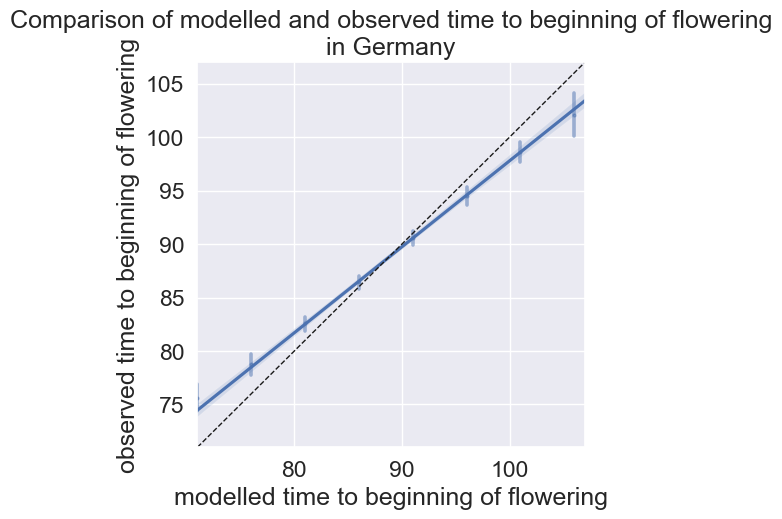

In [106]:
#fm_flowering_all_DE = np.array([0.34020292, 7.24511043, 24.10650321, 39.69694962])#DE params
train_a, test_a = train_test_split(ds_inputs_DE, test_size=0.2, random_state = 1)
ca_flowering = run_GDD_and_plot(fm_flowering_all_DE[0][0], test_a, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20],  method = 'regression', title_extra = 'in Germany', savename = 'DE_GDD_skill.png')

Text(0.5, 1.0, 'Discrepancy between GDD model and CCNN')

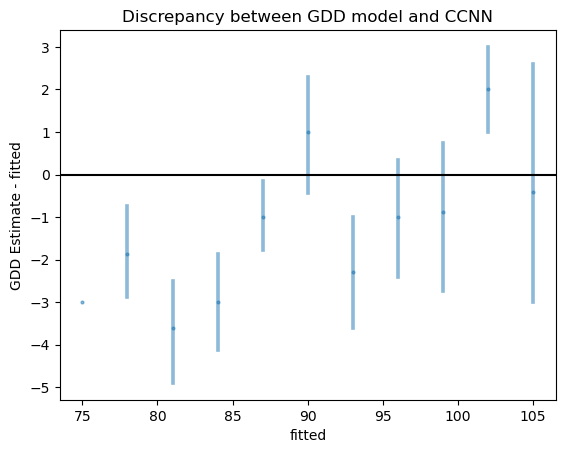

In [26]:
train_indices = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\temp_CCNN_training.csv')
test_indices = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\temp_CCNN_output.csv')
train_indices = train_indices.rename(columns = {'year': 'Referenzjahr'})
test_indices = test_indices.rename(columns = {'year': 'Referenzjahr'})
train = pd.merge(ds_inputs_DE, train_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
test = pd.merge(ds_inputs_DE, test_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
check = pd.merge(test_indices[['Stations_id', 'Referenzjahr', 'fitted', 'observed']], ca_flowering[['Stations_id', 'Referenzjahr', 'modelled time to beginning of flowering']], on = ['Stations_id', 'Referenzjahr'])
#check['fitted'] = check['fitted'] - check['observed']
#check['modelled time to beginning of flowering'] = check['modelled time to beginning of flowering'] - check['observed']
check['discrepancy'] = check['modelled time to beginning of flowering'] - check['fitted']
maxval = check['fitted'].max()#max(check['fitted'].max(), check['discrepancy'].max())
minval = check['fitted'].min()#min(check['fitted'].min(), check['discrepancy'].min())
fig, ax = plt.subplots()
sns.regplot(x='fitted', y='discrepancy', data = check, ax=ax,
            scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 3),
            fit_reg = False)
#fig, ax = plt.subplots()
#sns.regplot(x = 'modelled time to beginning of flowering', y = 'fitted', data = check, ax = ax)
#ax.plot([minval - 5, maxval + 5], [minval - 5, maxval + 5], color = 'k')
ax.set_ylabel('GDD Estimate - fitted')
ax.axhline(0, color = 'k')
ax.set_title('Discrepancy between GDD model and CCNN')

Text(0.5, 1.0, 'Comparison between residuals for CCNN and GDD model')

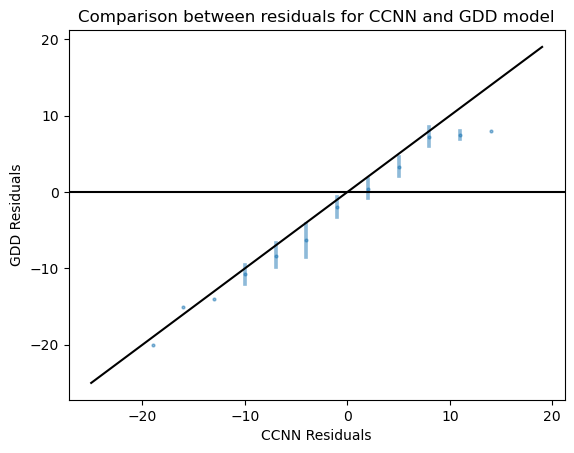

In [44]:
train_indices = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\temp_CCNN_training.csv')
test_indices = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\temp_CCNN_output.csv')
train_indices = train_indices.rename(columns = {'year': 'Referenzjahr'})
test_indices = test_indices.rename(columns = {'year': 'Referenzjahr'})
train = pd.merge(ds_inputs_DE, train_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
test = pd.merge(ds_inputs_DE, test_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
check = pd.merge(test_indices[['Stations_id', 'Referenzjahr', 'fitted', 'observed']], ca_flowering[['Stations_id', 'Referenzjahr', 'modelled time to beginning of flowering']], on = ['Stations_id', 'Referenzjahr'])
check['GDD Residuals'] = check['modelled time to beginning of flowering'] - check['observed']
check['CCNN Residuals'] = check['fitted'] - check['observed']
maxval = max(check['GDD Residuals'].max(), check['CCNN Residuals'].max())
minval = min(check['GDD Residuals'].min(), check['CCNN Residuals'].min())
fig, ax = plt.subplots()
sns.regplot(x='CCNN Residuals', y='GDD Residuals', data = check, ax=ax,
            scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 3),
            fit_reg = False)
#fig, ax = plt.subplots()
#sns.regplot(x = 'modelled time to beginning of flowering', y = 'fitted', data = check, ax = ax)
ax.plot([minval - 5, maxval + 5], [minval - 5, maxval + 5], color = 'k')
#ax.set_ylabel('GDD Estimate - fitted')
ax.axhline(0, color = 'k')
ax.set_title('Comparison between residuals for CCNN and GDD model')

In [23]:
#test_indices = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\temp_CCNN_output.csv')
compare_results = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\compare_CCNN_results.csv')
compare_results = compare_results.rename(columns = {'Stations_id': 'Referenzjahr', 'year': 'Stations_id'})
test = pd.merge(ds_inputs_DE, compare_results[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
check = pd.merge(compare_results[['Stations_id', 'Referenzjahr', 'Temp model', 'SAT model', 'observed']], ca_flowering[['Stations_id', 'Referenzjahr', 'modelled time to beginning of flowering']], on = ['Stations_id', 'Referenzjahr'])

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_6396\1201343894.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([check['modelled time to beginning of flowering'] - check['observed'],


Text(0.5, 0, 'Residuals DTF')

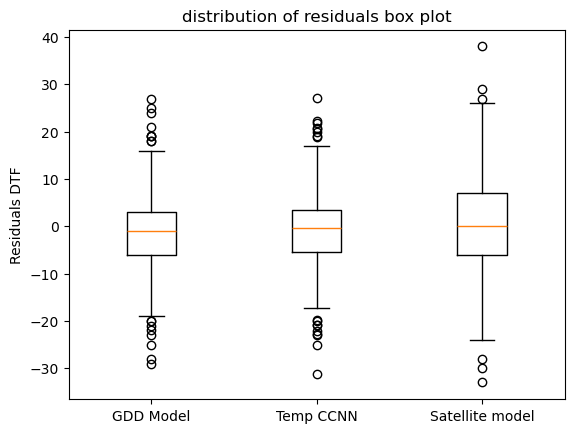

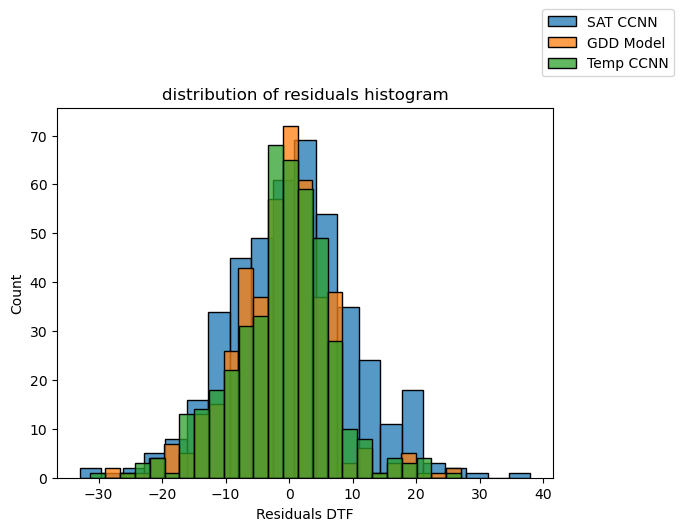

In [34]:
fig, ax = plt.subplots()
ax.boxplot([check['modelled time to beginning of flowering'] - check['observed'], 
            check['Temp model'] - check['observed'], 
            check['SAT model'] - check['observed']],  labels = ['GDD Model', 'Temp CCNN', 'Satellite model'])
ax.set_ylabel('Residuals DTF')
ax.set_title('distribution of residuals box plot')
fig, ax = plt.subplots()
sns.histplot(check['SAT model'] - check['observed'], label = 'SAT CCNN', ax=ax)
sns.histplot(check['modelled time to beginning of flowering'] - check['observed'], label = 'GDD Model', ax=ax)
sns.histplot(check['Temp model'] - check['observed'], label = 'Temp CCNN', ax=ax)
fig.legend(bbox_to_anchor = (1.1, 1.1))
ax.set_title('distribution of residuals histogram')
ax.set_xlabel('Residuals DTF')

In [43]:
import skill_metrics as sm
taylor_stats1 = sm.taylor_statistics(check['Temp model'],check['observed'],'data')
taylor_stats2 = sm.taylor_statistics(check['SAT model'],check['observed'],'data')
taylor_stats3 = sm.taylor_statistics(check['modelled time to beginning of flowering'],check['observed'],'data')

In [44]:
sdev = np.array([taylor_stats1['sdev'][0], taylor_stats1['sdev'][1], 
                    taylor_stats2['sdev'][1], taylor_stats3['sdev'][1]])
crmsd = np.array([taylor_stats1['crmsd'][0], taylor_stats1['crmsd'][1], 
                    taylor_stats2['crmsd'][1], taylor_stats3['crmsd'][1]])
ccoef = np.array([taylor_stats1['ccoef'][0], taylor_stats1['ccoef'][1], 
                    taylor_stats2['ccoef'][1], taylor_stats3['ccoef'][1]])

In [50]:
label = ['Temp CCNN', 'Temp CCNN', 'SAT CCNN', 'GDD']

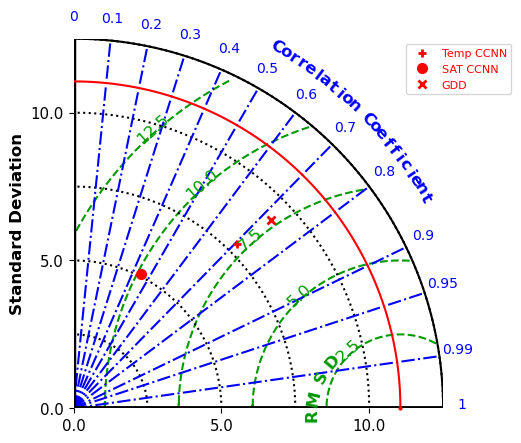

In [52]:
sm.taylor_diagram(sdev,crmsd,ccoef, markerLabel = label, markerLabelColor = 'r', 
                          markerLegend = 'on', markerColor = 'r',
                          styleOBS = '-', colOBS = 'r', markerobs = 'o',
                          markerSize = 6,)

0 stations out of 441 did not reach the end of phase 'beginning of flowering'
R^2 value for model: 0.5073419290278791
Bias: 0.26729603405989316 (sign 1.0)
Variance of modelled values: 85.37001649144494


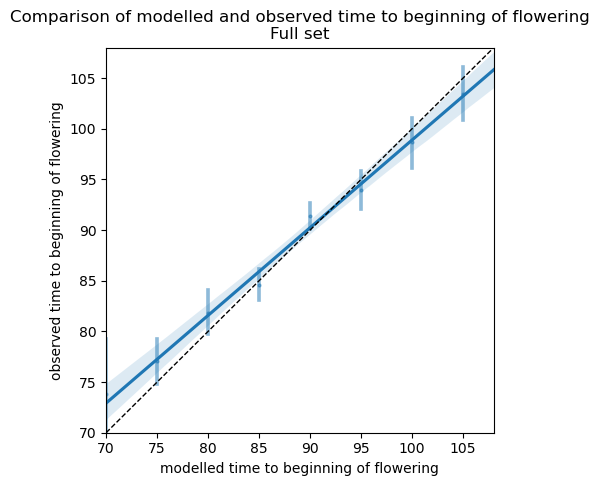

In [22]:
train_a, test_a = train_test_split(ds_inputs_DE, test_size=0.2, random_state = 1)
test_indices = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\model_output\\compare_CCNN_results.csv')
#train_indices = train_indices.rename(columns = {'year': 'Referenzjahr'})
test_indices = test_indices.rename(columns = {'Stations_id': 'Referenzjahr', 'year': 'Stations_id'})
test = pd.merge(ds_inputs_DE, test_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
complement_indices = ds_inputs_DE.index.difference(test.index)

fm_flowering_all_DE = np.array([0.36883787, 7.33177754, 25.34427389, 39.48075322])
# Filter df2 to keep only the rows with the complement indices
train = ds_inputs_DE.loc[complement_indices]
#train = pd.merge(ds, train_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
#test = pd.merge(ds_inputs_DE, test_indices[['Stations_id', 'Referenzjahr']], on = ['Stations_id', 'Referenzjahr'])
ca_flowering = run_GDD_and_plot(fm_flowering_all_DE, test, 't2m', response_type='Wang', phase_list = ['beginning of flowering'], exclude_unfinished=False, growing_period_length=300, 
                                        thresholds = [20], title_extra='Full set', method = 'regression')#np.concatenate((np.array([0.5]), fm_flowering_all[0][0][1:]))

In [128]:
x0 = np.array([11.36, 5.757, 22.68, 25.17, 45])
x0 = np.array([11.36, 5.757, 22.68, 35, 45])
x0 = np.array([1, 5.757, 26, 45])
#x0 = fm2s[0]
x0 = np.ones(20)*0.3
x0 = x
thresholds = [100]
phase_list = ['beginning of flowering']
response_type = 'Spline'
ds = ds_inputs_DE #train
grad_algebraic = run_GDD_and_get_RMSE_derivs(x0, ds.drop_duplicates(), 't2m', response_type = response_type,
                                             thresholds = thresholds, phase_list = phase_list)
for h in [0.001]:#, 0.01, 0.1]:0.00005, 0.0001,
    print(h)
    grads_numeric0 = []
    grads_numeric1 = []
    grads_numeric2 = []
    for x_index in range(len(x0)):
        if x_index % 4 != 1:
            continue
        print(x_index)
        x_plus_h = x0
        x_minus_h =  x0
        h_perturb = [0 for count in range(len(x0))]
        h_perturb[x_index] = h
        h_perturb = np.array(h_perturb)
        x_plus_h = x_plus_h + h_perturb
        x_minus_h = x_minus_h - h_perturb
        #print(x_minus_h, x_plus_h)
        grad_numeric = (run_GDD_and_get_RMSE(x_plus_h, ds.drop_duplicates(), 't2m', response_type = response_type, thresholds = thresholds, phase_list = phase_list) - run_GDD_and_get_RMSE(x_minus_h, ds.drop_duplicates(), 't2m', response_type = response_type, thresholds = thresholds, phase_list = phase_list))/(2*h)
        grads_numeric0.append(grad_numeric)
        grad_numeric = (run_GDD_and_get_RMSE(x_plus_h, ds.drop_duplicates(), 't2m', response_type = response_type, thresholds = thresholds, phase_list = phase_list) - run_GDD_and_get_RMSE(x0, ds.drop_duplicates(), 't2m', response_type = response_type, thresholds = thresholds, phase_list = phase_list))/h
        grads_numeric1.append(grad_numeric)
        grad_numeric = (run_GDD_and_get_RMSE(x0, ds.drop_duplicates(), 't2m', response_type = response_type, thresholds = thresholds, phase_list = phase_list) - run_GDD_and_get_RMSE(x_minus_h, ds.drop_duplicates(), 't2m', response_type = response_type, thresholds = thresholds, phase_list = phase_list))/h
        grads_numeric2.append(grad_numeric)
    
    print(grads_numeric0, grads_numeric1, grads_numeric2, grad_algebraic[[n for n in range(1, 19, 4)]])

0.001
1
5
9
13
17


TypeError: list indices must be integers or slices, not list

In [129]:
print(grads_numeric0, grads_numeric1, grads_numeric2, grad_algebraic)#[[n for n in range(1, 19, 4)]])

[0.20991481400578493, 8.066684334754548, 10.293885211700271, -0.027820351355067885, 0.0] [0.3743051021736221, 9.661799040037167, 12.506528390019866, 0.020233057691498857, 0.0] [0.04552452583794775, 6.471569629471929, 8.081242033380676, -0.07587376040163463, 0.0] [-11787.111100291328, -12092.905554133962, -13119.397434783805, -14322.149958013186, -14490.210541700244, -17976.92905523983, -25075.45339599726, -28497.992132376556, -24009.992323399838, -17637.672469076613, -14815.885423637246, -11461.919054935963, -6217.454683318368, -1808.442075708689, -316.0008983405145, -83.416403824503, -3.6557752752794084, -0.0022480797054191563, -0.0, -0.0]
